# Glucose Level Forecasting: Advanced Data Analysis and Patient Profiling

---

## About the Dataset

This dataset contains comprehensive records of blood glucose readings collected from multiple patients, along with demographic, clinical, and lifestyle information. Each row represents a single glucose measurement tied to a specific patient and time point.

**Key features include:**
- **id**: Unique identifier for each patient
- **gl**: Blood glucose reading (target variable)
- **time**: Timestamp of the glucose measurement
- **Demographics**: Gender, race, education level, income, marital status
- **Clinical history**: Diagnosed conditions (hypertension, diabetes duration, comorbidities)
- **Lifestyle**: Exercise, alcohol use, dietary supplements
- **Medications**: Binary flags for common prescriptions

**Purpose of Analysis:**
- Explore patient-wise glucose patterns
- Conduct advanced statistical and visual analyses
- Generate actionable insights for glucose forecasting and diabetes management

---


In [58]:
!pip install scikit-learn matplotlib pandas tensorflow --quiet



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [59]:
pip install upsetplot


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
!pip install prophet



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [61]:
pip install joypy



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##  Import Libraries


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

## 1. Data Overview and Data Card

This section summarizes the dataset's structure, including columns, types, shape, and missing data.  
A data card helps to quickly assess data quality and key features for further analysis.


In [63]:
# Load the dataset
df = pd.read_csv("/Users/mine/office/finalyearproject/raw_data/weinstock.csv")





## 🩸 Insulin Dataset Quick Overview

A comprehensive summary of the dataset, including structure, data types, missing values, unique categories, statistical highlights, and memory usage.


In [64]:
def check_insulin_df(df, head=5):
    """
    Comprehensive summary of clinical/biometric data for insulin forecasting.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    head : int, default=5
        Number of rows to show from head and tail.
        
    Returns
    -------
    None. Prints info to screen.
    """
    import pandas as pd
    # --- Validation ---
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    if not isinstance(head, int) or head < 1:
        raise ValueError("head must be a positive integer")
    
    def print_section_header(number, title):
        print(f"\n{number} {title}")
        print("━" * 60)

    print("\n🩸 Insulin Dataset Quick Overview")
    print("━" * 60)

    # 1. Basic Info
    print_section_header("1️⃣", "Basic Information")
    print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]:,}")
    print(f"Target column: 'unitsinstotal'")
    print(f"Timestamp column: 'time'")
    
    # 2. Data Types, Missing, Null
    print_section_header("2️⃣", "Column Types & Null Values")
    dtype_df = pd.DataFrame({
        'Type': df.dtypes,
        'Non-Null': df.count(),
        'Null': df.isnull().sum(),
        'Null %': (df.isnull().sum() / len(df) * 100).round(2).astype(str) + '%'
    }).reset_index().rename(columns={'index': 'Column'})
    print(dtype_df.to_string(index=False))

    # 3. Unique values for categorical features
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print_section_header("3️⃣", "Categorical Feature Cardinality")
        for col in categorical_cols:
            print(f"- {col}: {df[col].nunique()} unique values | Top: {df[col].unique()[:5]}")
    
    # 4. Head and Tail
    print_section_header("4️⃣", f"First {head} Rows")
    print(df.head(head))
    print_section_header("5️⃣", f"Last {head} Rows")
    print(df.tail(head))
    
    # 5. Numeric Stats
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    if len(numeric_cols) > 0:
        print_section_header("6️⃣", "Numeric Summary (including outlier quantiles)")
        desc = df[numeric_cols].describe([0, .05, .5, .95, .99, 1]).T.round(2)
        desc['count'] = desc['count'].astype(int)
        print(desc)
        print("\nPotential outliers (values at 0.99 or 1.00 quantile) are flagged above.")

    # 6. Memory Usage
    print_section_header("7️⃣", "Memory Usage")
    mem_total = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Total: {mem_total:.2f} MB")
    print("By column (MB):")
    print(df.memory_usage(deep=True).sort_values(ascending=False) / 1024**2)
    print("━" * 60)
    
check_insulin_df(df, head=10)


🩸 Insulin Dataset Quick Overview
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1️⃣ Basic Information
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Rows: 645,030 | Columns: 41
Target column: 'unitsinstotal'
Timestamp column: 'time'

2️⃣ Column Types & Null Values
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                            Column    Type  Non-Null  Null Null %
                                id   int64    645030     0   0.0%
                                gl float64    645030     0   0.0%
                              time  object    645030     0   0.0%
                            Gender  object    645030     0   0.0%
                              Race  object    645030     0   0.0%
                          EduLevel   int64    645030     0   0.0%
                         AnnualInc   int64    645030     0   0.0%
                     MaritalStatus  object    645030     0   0.0%
                          DaysWkEx float64    6450

## Variable Type Analysis

In this section, we identify and summarize the different types of variables present in the dataset. This helps guide further analysis, feature engineering, and preprocessing steps.

- **Categorical Columns:**  
  Variables that represent discrete groups or categories (e.g., gender, marital status).

- **Numeric Columns:**  
  Variables that contain continuous or discrete numerical values (e.g., age, income, glucose level).

- **Cardinal Columns:**  
  High-cardinality categorical variables, typically those with many unique values (e.g., user ID, postcode), which may require special encoding strategies.

A clear understanding of variable types ensures that appropriate methods are used for data cleaning, encoding, and modeling.


In [65]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns lists of categorical, numerical, and cardinal categorical variables for clinical/biometric datasets.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Input dataset.
    cat_th : int, default=10
        Threshold for numeric-but-categorical detection.
    car_th : int, default=20
        Threshold for cardinality in categorical columns.
        
    Returns
    -------
    cat_cols : list
        Categorical variable names
    num_cols : list
        Numeric variable names
    cat_but_car : list
        Categorical but cardinal variable names
    """
    # 1. Categorical
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes in [int, float]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # 2. Numeric
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in [int, float]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print("\n📊 Variable Analysis Report")
    print("━" * 50)
    print(f"Observations: {dataframe.shape[0]:,} | Variables: {dataframe.shape[1]}")

    print("\n- Categorical Variables:", len(cat_cols))
    print("- Numeric Variables:", len(num_cols))
    print("- Cardinal Categorical Variables:", len(cat_but_car))
    print("- Numeric but Categorical Variables:", len(num_but_cat))

    if len(cat_cols) > 0:
        print("\nCategorical:")
        for col in cat_cols:
            print(f"  ▫️ {col} ({dataframe[col].nunique()} unique)")
    if len(num_cols) > 0:
        print("\nNumeric:")
        for col in num_cols:
            print(f"  ▫️ {col} ({dataframe[col].nunique()} unique)")
    if len(num_but_cat) > 0:
        print("\nNumeric but Categorical:")
        for col in num_but_cat:
            print(f"  ▫️ {col} ({dataframe[col].nunique()} unique)")
    if len(cat_but_car) > 0:
        print("\nCardinal Categorical:")
        for col in cat_but_car:
            print(f"  ▫️ {col} ({dataframe[col].nunique()} unique)")
    print("━" * 50)
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)



📊 Variable Analysis Report
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Observations: 645,030 | Variables: 41

- Categorical Variables: 31
- Numeric Variables: 9
- Cardinal Categorical Variables: 1
- Numeric but Categorical Variables: 27

Categorical:
  ▫️ Gender (2 unique)
  ▫️ Race (5 unique)
  ▫️ MaritalStatus (8 unique)
  ▫️ InsDeliveryMethod (2 unique)
  ▫️ AnnualInc (8 unique)
  ▫️ DaysWkEx (8 unique)
  ▫️ DaysMonBingeAlc (4 unique)
  ▫️ NumHospDKA (3 unique)
  ▫️ NumSHSinceT1DDiag (8 unique)
  ▫️ Hypertension (2 unique)
  ▫️ Hyperlipidemia (2 unique)
  ▫️ Hypothyroidism (2 unique)
  ▫️ Depression (2 unique)
  ▫️ Coronary artery disease (2 unique)
  ▫️ Diabetic peripheral neuropathy (2 unique)
  ▫️ Dyslipidemia (2 unique)
  ▫️ Chronic kidney disease (2 unique)
  ▫️ Osteoporosis (2 unique)
  ▫️ Proliferative diabetic retinopathy (2 unique)
  ▫️ Hypercholesterolemia (2 unique)
  ▫️ Erectile dysfunction (2 unique)
  ▫️ Type I diabetes mellitus (2 unique)
  ▫️ Aspirin (2 uniqu

## 2. Exploratory Data Analysis (EDA)

This section explores the dataset to understand distributions, detect issues, and prepare for modeling.  
A crucial step is **data cleanup**, ensuring quality by addressing missing values, invalid entries, and data types.

---

### 2.1 Data Inspection & Cleanup

- Standardize column names for consistency
- Identify and handle missing values
- Correct data types (e.g., convert time to datetime)
- Remove or flag duplicates
- Address outliers and erroneous values

Cleaning data at this stage improves the accuracy of downstream analysis and modeling.

In [66]:
# 1. Standardize column names for consistency
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# 2. Identify and handle missing values
# Show % missing per column
print("Missing value percentage per column:")
print(df.isnull().mean().sort_values(ascending=False) * 100)

# Example: Drop rows with missing glucose or time (adjust as needed)
df = df.dropna(subset=['gl', 'time'])

# Optionally, fill missing for other columns (customize as needed)
# df['some_column'] = df['some_column'].fillna(df['some_column'].median())

# 3. Correct data types (convert time to datetime)
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 4. Remove or flag duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

# 5. Address outliers and erroneous values in 'gl'
# Example: Remove glucose values outside 1st–99th percentile as outliers
q_low = df['gl'].quantile(0.01)
q_high = df['gl'].quantile(0.99)
df = df[(df['gl'] >= q_low) & (df['gl'] <= q_high)]

print("Data cleaned. Shape after cleaning:", df.shape)


Missing value percentage per column:
id                                    0.0
hypothyroidism                        0.0
coronary_artery_disease               0.0
diabetic_peripheral_neuropathy        0.0
dyslipidemia                          0.0
chronic_kidney_disease                0.0
osteoporosis                          0.0
proliferative_diabetic_retinopathy    0.0
hypercholesterolemia                  0.0
erectile_dysfunction                  0.0
type_i_diabetes_mellitus              0.0
aspirin                               0.0
simvastatin                           0.0
lisinopril                            0.0
vitamin_d                             0.0
multivitamin_preparation              0.0
omeprazole                            0.0
atorvastatin                          0.0
synthroid                             0.0
depression                            0.0
hyperlipidemia                        0.0
gl                                    0.0
hypertension                          0

### 2.2 Gender Distribution of Patients (Advanced Pie Chart)

This chart visualizes the proportion of unique male and female patients in the study population,  
providing a clear summary of cohort gender representation for demographic assessment and downstream modeling fairness.




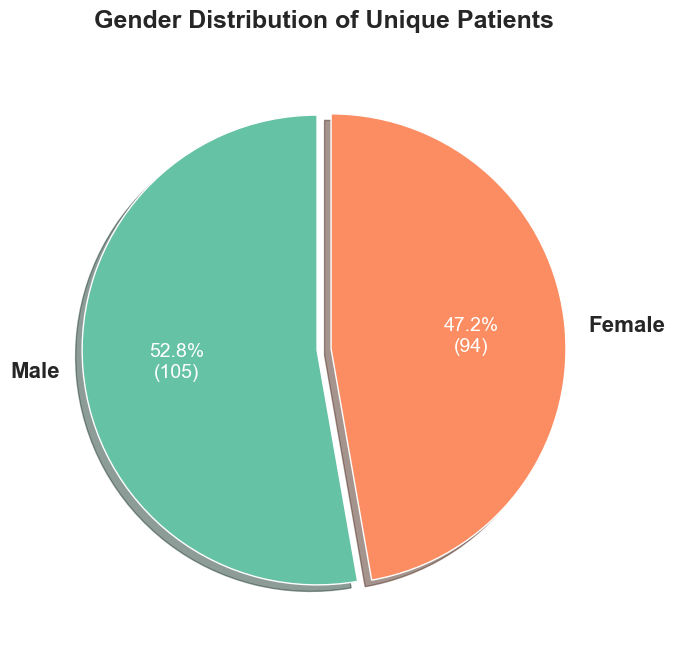

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Robust standardization and clean-up of gender column
df['gender'] = df['gender'].astype(str).str.strip().str.lower()
gender_map = {'male': 'Male', 'm': 'Male', 'female': 'Female', 'f': 'Female'}
df['gender'] = df['gender'].map(gender_map).fillna('Other')

# Only keep known genders
patient_gender = df.drop_duplicates('id')[['id', 'gender']]
gender_counts = patient_gender['gender'].value_counts()
present_labels = gender_counts.index.tolist()
present_values = gender_counts.values

# Set professional colors (use as many as needed)
color_palette = sns.color_palette("Set2", n_colors=len(present_labels))

# Handle the case of missing or all-unknown gender data
if len(present_values) == 0:
    print("No valid gender information found for patients.")
else:
    # Annotate with count and percentage
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            count = int(round(pct * total / 100.0))
            return '{:.1f}%\n({:d})'.format(pct, count)
        return my_autopct

    # Advanced pie chart
    plt.figure(figsize=(7,7))
    patches, texts, autotexts = plt.pie(
        present_values,
        labels=present_labels,
        colors=color_palette,
        autopct=make_autopct(present_values),
        startangle=90,
        explode=[0.03] * len(present_values),
        shadow=True,
        textprops={'fontsize': 14, 'weight': 'bold'}
    )

    plt.setp(texts, size=16, weight='bold')
    plt.setp(autotexts, size=14, weight='normal', color='white')
    plt.title('Gender Distribution of Unique Patients', fontsize=18, weight='bold', pad=20)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()


In [68]:
def target_summary_with_num(dataframe, target, numerical_cols, is_target_cat=None, max_unique=None):
    """
    Analyzes the relationship between target variable and numerical variables.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data
    target : str
        Name of the target variable column
    numerical_cols : str or list
        Single column name or list of numerical column names to analyze
    is_target_cat : bool, optional
        If True, target is treated as categorical
        If False, target is treated as numerical
        If None, type is automatically detected (default)
    max_unique : int, optional
        Maximum unique values for target to be considered categorical
    """
    def print_section(title, content=""):
        """Helper function to print formatted sections"""
        print(f"\n{title}")
        print("▰▱" * 25)
        if content:
            print(content)

    def analyze_categorical_target(col):
        """Helper function for categorical target analysis"""
        stats = dataframe.groupby(target)[col].agg(['count', 'mean', 'median', 
                                                   'min', 'max', 'std']).round(2)
        
        # Calculate additional metrics
        stats['ratio'] = (100 * stats['count'] / len(dataframe)).round(2)
        stats['ratio'] = stats['ratio'].astype(str) + '%'
        
        overall_mean = dataframe[col].mean()
        stats['diff_from_mean'] = (100 * (stats['mean'] - overall_mean) / overall_mean).round(2)
        stats['diff_from_mean'] = stats['diff_from_mean'].apply(
            lambda x: f"+{x}%" if x > 0 else f"{x}%")

        print_section(f"📈 Analysis of {col} by {target}")
        
        # Print summary statistics
        print("\n📊 Summary Statistics by Target Class:")
        print(stats.rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'median': 'Median',
            'min': 'Min',
            'max': 'Max',
            'std': 'Std',
            'ratio': 'Ratio(%)',
            'diff_from_mean': 'Diff from Mean(%)'
        }))

        # Print insights
        print("\n📈 Key Insights:")
        print(f"▫️ Overall Mean: {overall_mean:.2f}")
        print(f"▫️ Class with Highest Mean: {stats['mean'].idxmax()} ({stats['mean'].max():.2f})")
        print(f"▫️ Class with Lowest Mean: {stats['mean'].idxmin()} ({stats['mean'].min():.2f})")
        print(f"▫️ Mean Range: {stats['mean'].max() - stats['mean'].min():.2f}")

    def analyze_numerical_target(col):
        """Helper function for numerical target analysis"""
        print_section(f"📈 Analysis of {col}")
        
        # Calculate statistics
        stats = dataframe[col].agg(['mean', 'std', 'min', 'max']).round(2)
        quartiles = dataframe[col].quantile([0.25, 0.5, 0.75]).round(2)
        
        # Calculate correlation
        correlation = dataframe[[target, col]].corr().iloc[0, 1].round(3)
        
        print("\n📋 Distribution Statistics:")
        print(f"▫️ Mean: {stats['mean']}")
        print(f"▫️ Std: {stats['std']}")
        print(f"▫️ Q1 (25%): {quartiles[0.25]}")
        print(f"▫️ Median: {quartiles[0.5]}")
        print(f"▫️ Q3 (75%): {quartiles[0.75]}")
        print(f"▫️ IQR: {(quartiles[0.75] - quartiles[0.25]):.2f}")
        print(f"▫️ Correlation with target: {correlation}")

    # Input validation and preprocessing
    numerical_cols = [numerical_cols] if isinstance(numerical_cols, str) else numerical_cols

    # Determine if target is categorical
    if is_target_cat is None:
        is_target_categorical = (
            dataframe[target].dtype in ['object', 'category', 'bool'] or
            dataframe[target].nunique() <= (max_unique if max_unique else 2)
        )
    else:
        is_target_categorical = is_target_cat

    # Print main header
    print("\n📊 Target-Based Numerical Analysis Report")
    print("▰" * 70)

    # Print target information
    print_section("📋 Target Variable Information",
                 f"▫️ Variable Type: {'Categorical' if is_target_categorical else 'Numerical'}\n"
                 f"▫️ Unique Values: {dataframe[target].nunique()}")

    # Print target distribution if categorical
    if is_target_categorical:
        target_dist = pd.DataFrame({
            "Count": dataframe[target].value_counts(),
            "Ratio": (100 * dataframe[target].value_counts() / len(dataframe)).round(2)
        })
        target_dist["Ratio"] = target_dist["Ratio"].astype(str) + '%'
        print_section("📊 Target Class Distribution", target_dist.to_string())

    # Analyze each numerical column
    for col in numerical_cols:
        if is_target_categorical:
            analyze_categorical_target(col)
        else:
            analyze_numerical_target(col)

    print("\n" + "▰" * 70)

In [69]:
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# Typically numerical/continuous:
numerical_columns = [
    'id', 'gl', 'dayswkex', 'dayswkdrinkalc', 'daysmonbingealc',
    't1ddiagage', 'numhospdka', 'numshsincet1ddiag', 'annualinc',
    'unitsinstotal', 'nummetercheckday', 'height', 'weight', 'bmi'
]
target_summary_with_num(
    dataframe=df,
    target='gl',
    numerical_cols=numerical_columns,   # <-- Updated list
    is_target_cat=False                 # Because 'unitsinstotal' is continuous
)


📊 Target-Based Numerical Analysis Report
▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰▰

📋 Target Variable Information
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱
▫️ Variable Type: Numerical
▫️ Unique Values: 363

📈 Analysis of id
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 98.92
▫️ Std: 58.31
▫️ Q1 (25%): 48.0
▫️ Median: 98.0
▫️ Q3 (75%): 150.0
▫️ IQR: 102.00
▫️ Correlation with target: 0.022

📈 Analysis of gl
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 174.06
▫️ Std: 82.58
▫️ Q1 (25%): 112.0
▫️ Median: 161.0
▫️ Q3 (75%): 223.0
▫️ IQR: 111.00
▫️ Correlation with target: 1.0

📈 Analysis of dayswkex
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱

📋 Distribution Statistics:
▫️ Mean: 4.95
▫️ Std: 2.08
▫️ Q1 (25%): 4.0
▫️ Median: 5.0
▫️ Q3 (75%): 7.0
▫️ IQR: 3.00
▫️ Correlation with target: -0.003

📈 Analysis of dayswkdrinkalc
▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰▱▰

### **Correlation Heatmap of Numerical Features (Enhanced Visualization)**

**This advanced heatmap displays the pairwise correlations between key numerical features in the dataset.  
Only the lower triangle is shown to reduce redundancy, with a bold diverging color palette for clarity.  
Annotations use rounded, high-contrast backgrounds to maximize readability.  
This visualization enables rapid identification of meaningful linear relationships and potential multicollinearity among features.**


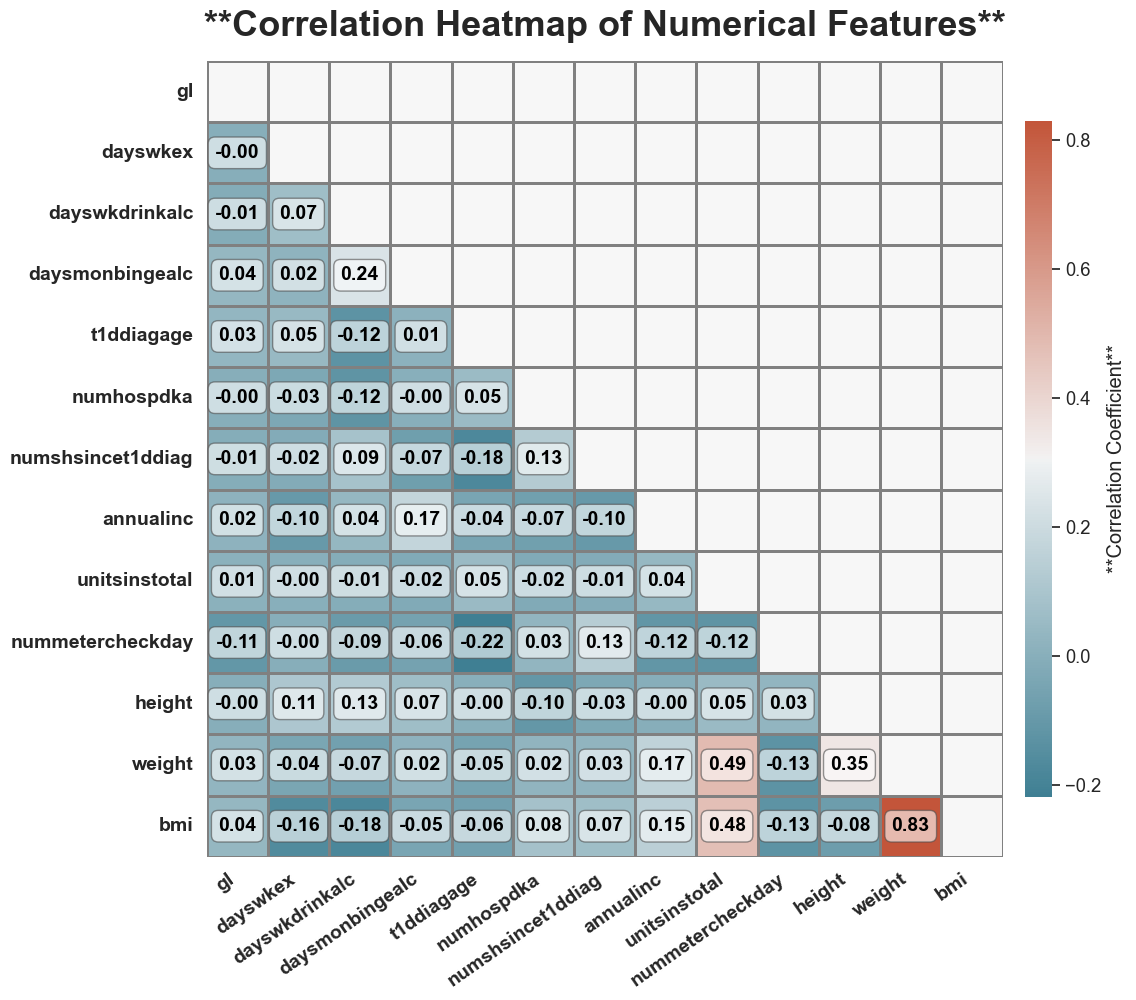

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally drop 'id' if not meaningful for correlation
plot_cols = [col for col in numerical_columns if col.lower() != 'id']
corr_matrix = df[plot_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 11))
sns.set(style="white", font_scale=1.2)

ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    linewidths=1.8,
    linecolor='grey',
    square=True,
    cbar_kws={
        "shrink": 0.85,
        'label': '**Correlation Coefficient**',
        'aspect': 25,
        'pad': 0.02
    },
    annot_kws={'size':14, 'weight':'bold', 'color':'black', 'bbox':dict(boxstyle='round,pad=0.35', facecolor='white', edgecolor='0.3', alpha=0.6)}
)

plt.title("**Correlation Heatmap of Numerical Features**", fontsize=26, fontweight='bold', pad=18)
plt.xticks(fontsize=14, fontweight='bold', rotation=35, ha='right')
plt.yticks(fontsize=14, fontweight='bold', rotation=0)
plt.gca().set_facecolor('#F7F7F7')  # Subtle background
plt.tight_layout(pad=3)
plt.show()


### **Patient-Wise Data Aggregation**

**To analyze data at the individual patient level, all available measurements are aggregated such that each patient appears only once in the dataset.  
Numeric variables (e.g., age at diagnosis, glucose, BMI) are summarized using their mean values, while categorical variables (e.g., gender, race) retain their first observed entry for each patient.  
This results in a clean, patient-wise dataset ideal for further statistical analysis and visualization.**


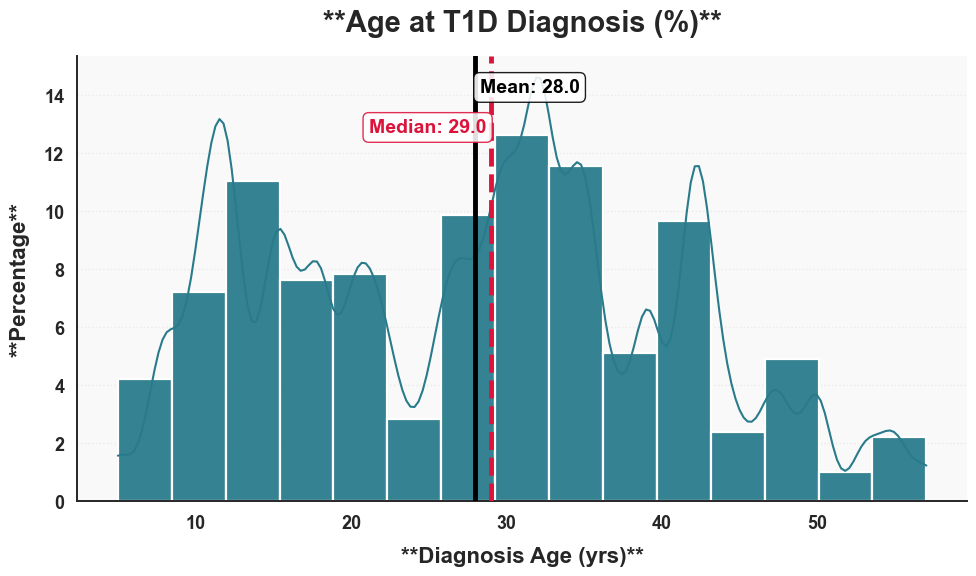

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

main_color = sns.color_palette("crest", n_colors=15)[8]

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor('#F9F9F9')

# Histogram and KDE
sns.histplot(
    df['t1ddiagage'],
    bins=15,
    kde=True,
    stat='percent',
    color=main_color,
    edgecolor='white',
    linewidth=1.6,
    alpha=0.94
)

mean_diag = df['t1ddiagage'].mean()
median_diag = df['t1ddiagage'].median()

# Highly contrasting, thick lines
plt.axvline(mean_diag, color='black', linestyle='-', linewidth=3.5, zorder=3)
plt.axvline(median_diag, color='crimson', linestyle='--', linewidth=3.5, zorder=3)

# Annotation for mean
plt.text(
    mean_diag + 0.3, plt.ylim()[1]*0.95, f"Mean: {mean_diag:.1f}",
    color='black', fontsize=14, fontweight='bold', va='top', ha='left',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.88)
)
# Annotation for median
plt.text(
    median_diag - 0.3, plt.ylim()[1]*0.86, f"Median: {median_diag:.1f}",
    color='crimson', fontsize=14, fontweight='bold', va='top', ha='right',
    bbox=dict(facecolor='white', edgecolor='crimson', boxstyle='round,pad=0.3', alpha=0.88)
)

plt.title("**Age at T1D Diagnosis (%)**", fontsize=21, fontweight='bold', pad=18)
plt.xlabel("**Diagnosis Age (yrs)**", fontsize=16, fontweight='bold', labelpad=10)
plt.ylabel("**Percentage**", fontsize=16, fontweight='bold', labelpad=10)
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.grid(axis='y', linestyle=':', alpha=0.32, linewidth=1)
sns.despine()
ax.spines['bottom'].set_linewidth(1.4)
ax.spines['left'].set_linewidth(1.4)
plt.tight_layout()
plt.show()


### **Glucose Distribution by Gender**

**This kernel density plot compares the distribution of glucose concentrations in blood between male and female patients.  
Separate curves for each gender enable clear visualization of differences in glucose profiles, with a vertical line indicating the overall median glucose value across all patients.  
This visualization assists in detecting gender-specific trends or disparities in glycemic control.**


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize gender column
df['gender'] = df['gender'].astype(str).str.strip().str.title()

# Plot settings
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['gender'] == 'Male']['gl'], shade=True, color='blue', label='Male', linewidth=2)
sns.kdeplot(df[df['gender'] == 'Female']['gl'], shade=True, color='red', label='Female', linewidth=2)

plt.xlabel(r'Glucose concentration in blood, $x$', fontsize=14, weight='bold')
plt.ylabel('Probability', fontsize=14, weight='bold')
plt.title('Glucose Distribution by Gender', fontsize=16, weight='bold')
plt.legend(fontsize=13, loc='upper right', frameon=False)
plt.axvline(df['gl'].median(), color='black', linestyle='-', linewidth=2)  # Optional: reference median line
plt.tight_layout()
plt.show()


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/3265667521.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['gender'] == 'Male']['gl'], shade=True, color='blue', label='Male', linewidth=2)
/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/3265667521.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['gender'] == 'Female']['gl'], shade=True, color='red', label='Female', linewidth=2)


### 2.14 Glucose Trends by Marital Status (12-Hour Intervals, Risk Zones Highlighted)

This plot shows mean glucose trends by marital status in 12-hour intervals,  
with background shading for clinically relevant glucose risk zones:
- Normal (70–100 mg/dL)
- Medium (100–180 mg/dL)
- High (>180 mg/dL)

---


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/1872497262.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['halfday'] = df['time'].dt.floor('12H')


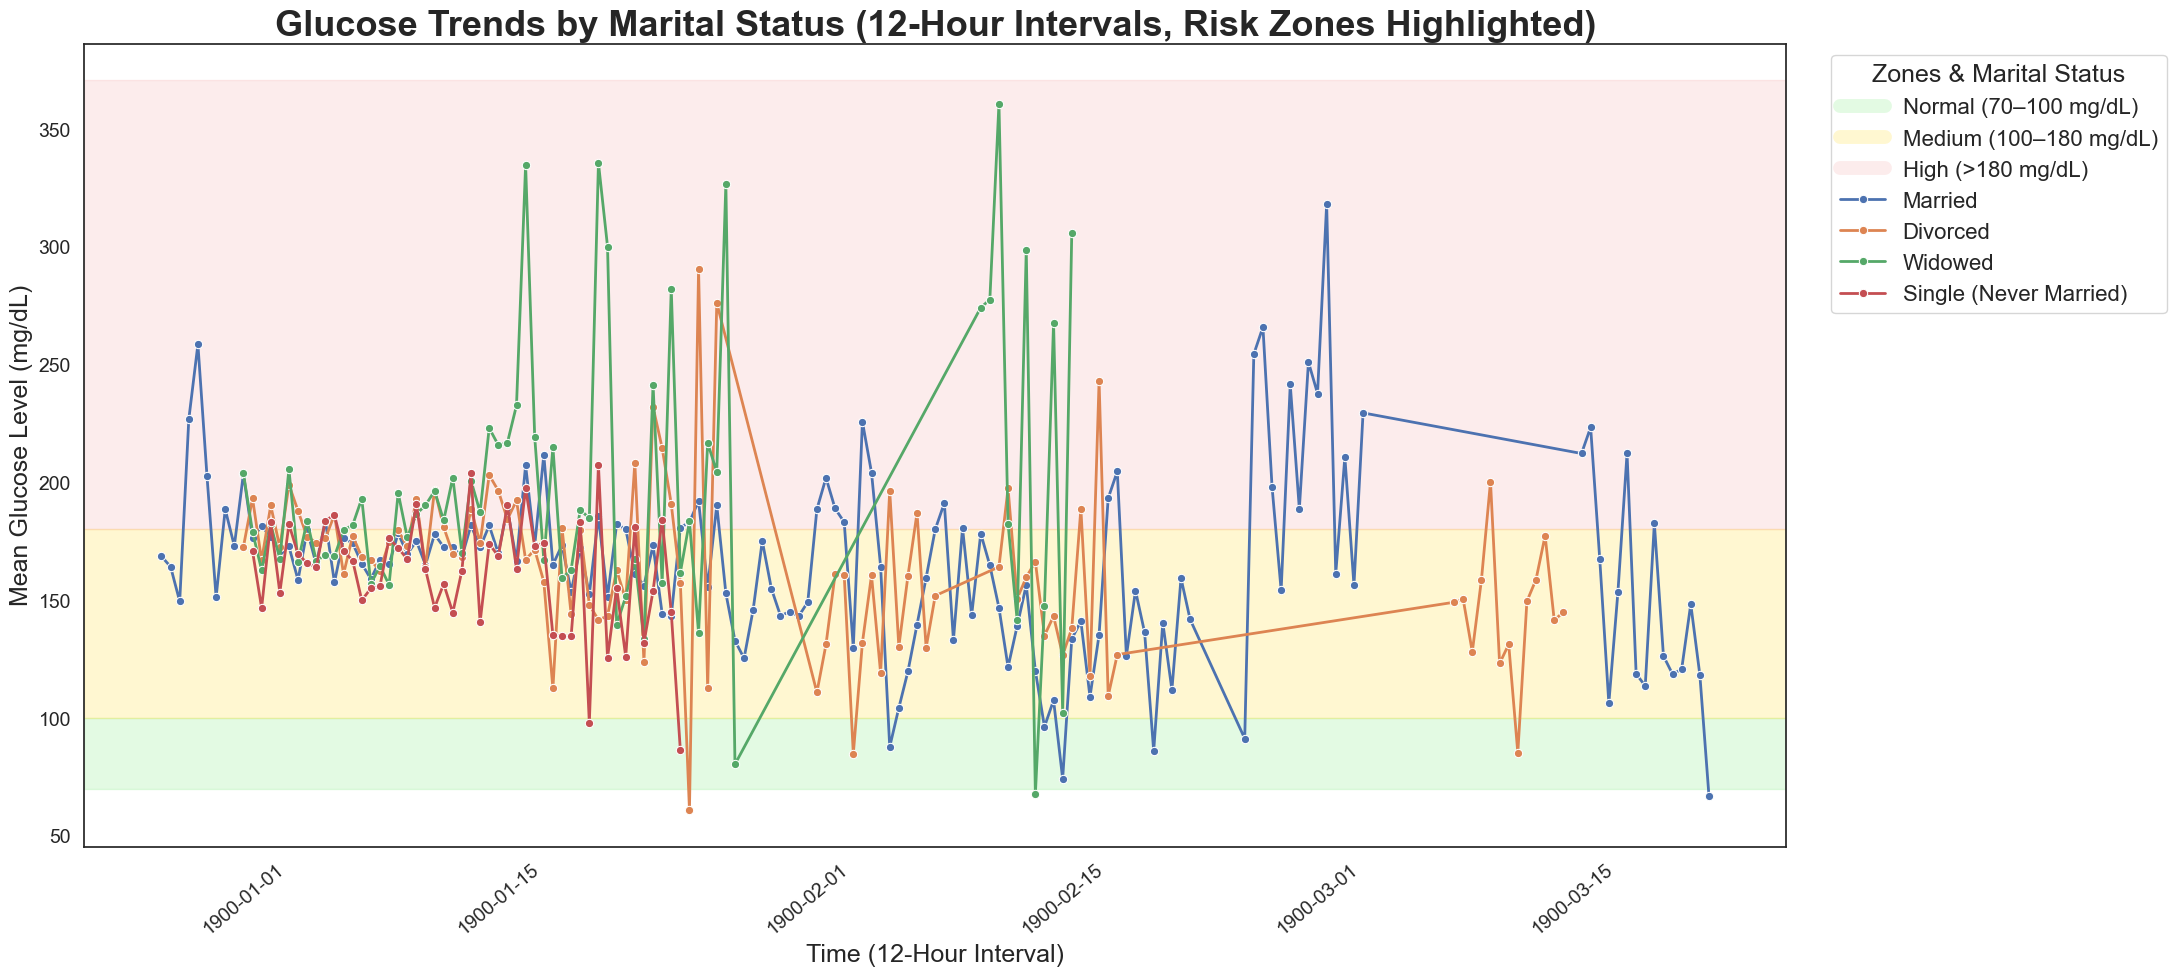

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['maritalstatus'] = df['maritalstatus'].astype(str).str.strip().str.title()
df['halfday'] = df['time'].dt.floor('12H')

# Aggregate by 12-hour period and marital status
trend_12h = df.groupby(['halfday', 'maritalstatus'])['gl'].mean().reset_index()
top_status = trend_12h['maritalstatus'].value_counts().index[:4]
trend_12h = trend_12h[trend_12h['maritalstatus'].isin(top_status)]

plt.figure(figsize=(22,10))

# 1. Highlight Normal Range (70-100)
plt.axhspan(70, 100, color='lightgreen', alpha=0.25, label='Normal (70–100 mg/dL)')

# 2. Highlight Medium Range (100-180)
plt.axhspan(100, 180, color='gold', alpha=0.18, label='Medium (100–180 mg/dL)')

# 3. Highlight High Range (>180)
plt.axhspan(180, trend_12h['gl'].max() + 10, color='lightcoral', alpha=0.15, label='High (>180 mg/dL)')

sns.lineplot(x='halfday', y='gl', hue='maritalstatus', data=trend_12h, marker='o', linewidth=2)

plt.title('Glucose Trends by Marital Status (12-Hour Intervals, Risk Zones Highlighted)', fontsize=26, weight='bold')
plt.xlabel('Time (12-Hour Interval)', fontsize=18)
plt.ylabel('Mean Glucose Level (mg/dL)', fontsize=18)

# Custom legend (avoid duplicate zone labels)
handles, labels = plt.gca().get_legend_handles_labels()
zone_labels = ['Normal (70–100 mg/dL)', 'Medium (100–180 mg/dL)', 'High (>180 mg/dL)']
zone_handles = [plt.Line2D([0], [0], color='lightgreen', linewidth=10, alpha=0.25),
                plt.Line2D([0], [0], color='gold', linewidth=10, alpha=0.18),
                plt.Line2D([0], [0], color='lightcoral', linewidth=10, alpha=0.15)]
plt.legend(zone_handles + handles[len(zone_labels):],
           zone_labels + labels[len(zone_labels):],
           title='Zones & Marital Status',
           bbox_to_anchor=(1.02, 1),
           loc='upper left',
           fontsize=16,
           title_fontsize=18)

plt.xticks(rotation=40, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


### 2.X Distribution of Mean Patient Glucose by Income Bin (Ridgeline Plot)

This ridgeline plot visualizes the distribution of average glucose levels among patients, grouped by income bin.  
Overlapping density curves enable clear comparison of glucose control patterns across socioeconomic strata, highlighting differences in the central tendency and variability between groups.

---


In [ ]:
df.columns.tolist()

['id',
 'gl',
 'time',
 'gender',
 'race',
 'edulevel',
 'annualinc',
 'maritalstatus',
 'dayswkex',
 'dayswkdrinkalc',
 'daysmonbingealc',
 't1ddiagage',
 'numhospdka',
 'numshsincet1ddiag',
 'insdeliverymethod',
 'unitsinstotal',
 'nummetercheckday',
 'height',
 'weight',
 'hypertension',
 'hyperlipidemia',
 'hypothyroidism',
 'depression',
 'coronary_artery_disease',
 'diabetic_peripheral_neuropathy',
 'dyslipidemia',
 'chronic_kidney_disease',
 'osteoporosis',
 'proliferative_diabetic_retinopathy',
 'hypercholesterolemia',
 'erectile_dysfunction',
 'type_i_diabetes_mellitus',
 'aspirin',
 'simvastatin',
 'lisinopril',
 'vitamin_d',
 'multivitamin_preparation',
 'omeprazole',
 'atorvastatin',
 'synthroid',
 'vitamin_d3',
 'bmi',
 'halfday']

/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/268897932.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


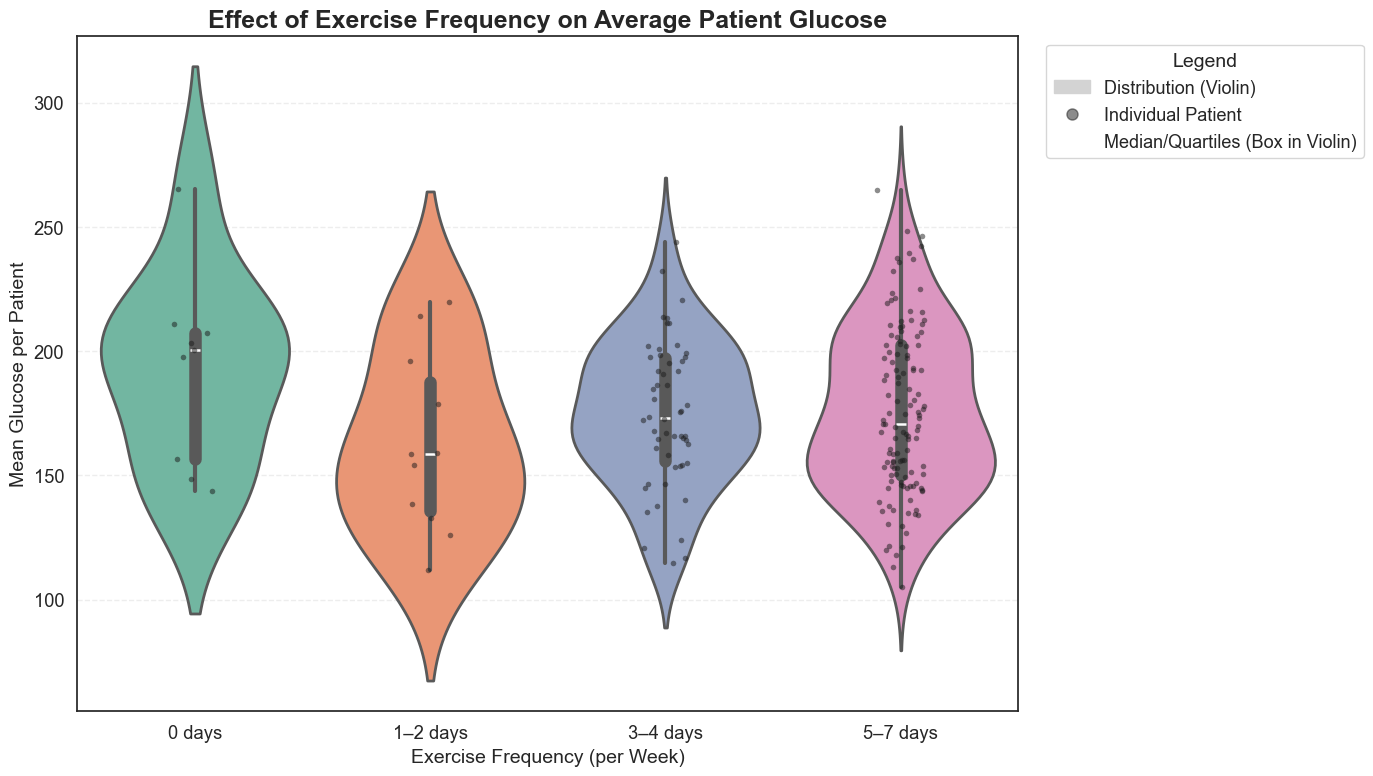

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Create lifestyle dataframe (exercise frequency vs mean glucose per patient)
patient_lifestyle = (
    df.groupby("id")
    .agg({
        "dayswkex": "mean",     # average exercise per patient
        "gl": "mean"            # mean glucose per patient
    })
    .reset_index()
    .rename(columns={"dayswkex": "lifestyle", "gl": "mean_glucose"})
)

# Define bins for exercise frequency
bins = [-0.1, 0.5, 2.5, 4.5, 7.5]  
labels = ['0 days', '1–2 days', '3–4 days', '5–7 days']

patient_lifestyle['lifestyle_group'] = pd.cut(
    patient_lifestyle['lifestyle'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# --- Visualization ---
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=patient_lifestyle,
    x='lifestyle_group',
    y='mean_glucose',
    palette='Set2',
    inner='box',
    linewidth=2
)
sns.stripplot(
    data=patient_lifestyle,
    x='lifestyle_group',
    y='mean_glucose',
    color='k',
    alpha=0.5,
    size=4
)

plt.title("Effect of Exercise Frequency on Average Patient Glucose", fontsize=18, fontweight='bold')
plt.xlabel("Exercise Frequency (per Week)", fontsize=14)
plt.ylabel("Mean Glucose per Patient", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.35)

# Custom legend
violin_patch = mpatches.Patch(color='lightgrey', label='Distribution (Violin)')
strip_patch = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, alpha=0.5, label='Individual Patient')
box_patch = mlines.Line2D([], [], color='white', marker='s', linestyle='None', markersize=12, markerfacecolor='white', markeredgewidth=2, label='Median/Quartiles (Box in Violin)')

plt.legend(handles=[violin_patch, strip_patch, box_patch],
           title='Legend',
           bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13, title_fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
df.columns.to_list()

['id',
 'gl',
 'time',
 'gender',
 'race',
 'edulevel',
 'annualinc',
 'maritalstatus',
 'dayswkex',
 'dayswkdrinkalc',
 'daysmonbingealc',
 't1ddiagage',
 'numhospdka',
 'numshsincet1ddiag',
 'insdeliverymethod',
 'unitsinstotal',
 'nummetercheckday',
 'height',
 'weight',
 'hypertension',
 'hyperlipidemia',
 'hypothyroidism',
 'depression',
 'coronary_artery_disease',
 'diabetic_peripheral_neuropathy',
 'dyslipidemia',
 'chronic_kidney_disease',
 'osteoporosis',
 'proliferative_diabetic_retinopathy',
 'hypercholesterolemia',
 'erectile_dysfunction',
 'type_i_diabetes_mellitus',
 'aspirin',
 'simvastatin',
 'lisinopril',
 'vitamin_d',
 'multivitamin_preparation',
 'omeprazole',
 'atorvastatin',
 'synthroid',
 'vitamin_d3',
 'bmi',
 'halfday']

### 2.X Effect of Alcohol Consumption Frequency on Average Patient Glucose

This plot explores how the frequency of alcohol consumption (days per week) is associated with average blood glucose levels among patients.  
Alcohol frequency is grouped into descriptive categories for clear interpretation, and both the group distributions and individual patient data are visualized.

---


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/3066063952.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


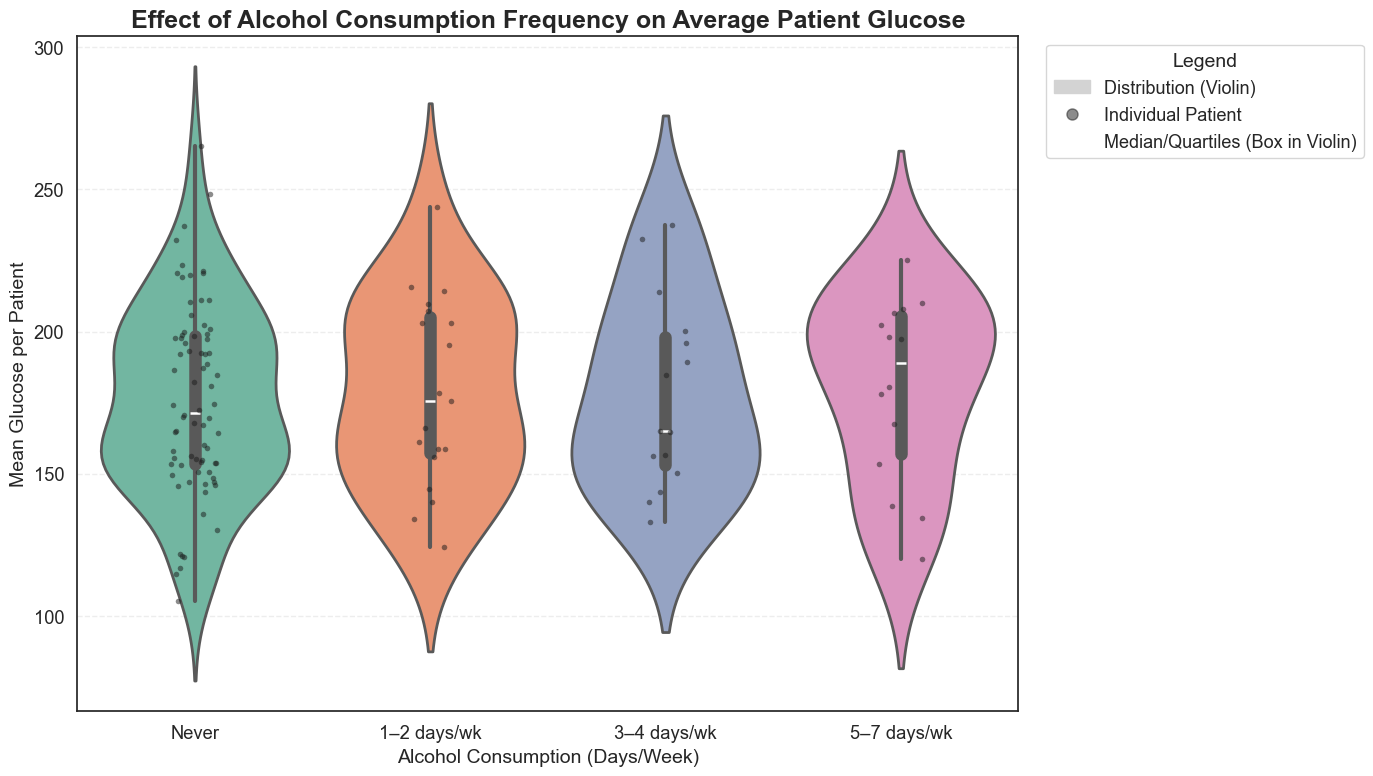

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Bin 'dayswkdrinkalc' for clear group labels
bins = [-0.1, 0.5, 2.5, 4.5, 7.5]  # 0, 1–2, 3–4, 5–7 days/week
labels = ['Never', '1–2 days/wk', '3–4 days/wk', '5–7 days/wk']

patient_alc = df.groupby('id').agg(
    mean_glucose=('gl', 'mean'),
    alc_days=('dayswkdrinkalc', 'mean')
).dropna()
patient_alc['alc_group'] = pd.cut(patient_alc['alc_days'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=patient_alc,
    x='alc_group',
    y='mean_glucose',
    palette='Set2',
    inner='box',
    linewidth=2
)
sns.stripplot(
    data=patient_alc,
    x='alc_group',
    y='mean_glucose',
    color='k',
    alpha=0.5,
    size=4
)

plt.title("Effect of Alcohol Consumption Frequency on Average Patient Glucose", fontsize=18, fontweight='bold')
plt.xlabel("Alcohol Consumption (Days/Week)", fontsize=14)
plt.ylabel("Mean Glucose per Patient", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.35)

# Custom legend
violin_patch = mpatches.Patch(color='lightgrey', label='Distribution (Violin)')
strip_patch = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, alpha=0.5, label='Individual Patient')
box_patch = mlines.Line2D([], [], color='white', marker='s', linestyle='None', markersize=12, markerfacecolor='white', markeredgewidth=2, label='Median/Quartiles (Box in Violin)')

plt.legend(handles=[violin_patch, strip_patch, box_patch],
           title='Legend',
           bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13, title_fontsize=14)

plt.tight_layout()
plt.show()


### 2.X Mean Glucose by Medication Group (Lollipop Plot)

This lollipop plot displays the mean glucose level for patients, grouped by each medication.  
Both patients taking and not taking the medication are compared for each group.  
Values are annotated for clarity, and the legend is positioned in the upper right corner for easy reference.

---


                 Medication  N (Takes Med)  N (No Med)  Glucose (Takes Med)  \
0               Simvastatin             63         136           172.418851   
1  Multivitamin Preparation             39         160           175.132762   
2                 Vitamin D             48         151           175.901712   
3                   Aspirin             91         108           177.790955   
4                 Synthroid             23         176           180.684172   
5              Atorvastatin             24         175           181.006103   
6                Lisinopril             51         148           182.588731   
7                Vitamin D3             20         179           182.709147   
8                Omeprazole             29         170           186.472459   

   Glucose (No Med)  Δ (With - Without)  
0        177.002281           -4.583430  
1        175.653251           -0.520489  
2        175.439839            0.461872  
3        173.664083            4.126871  

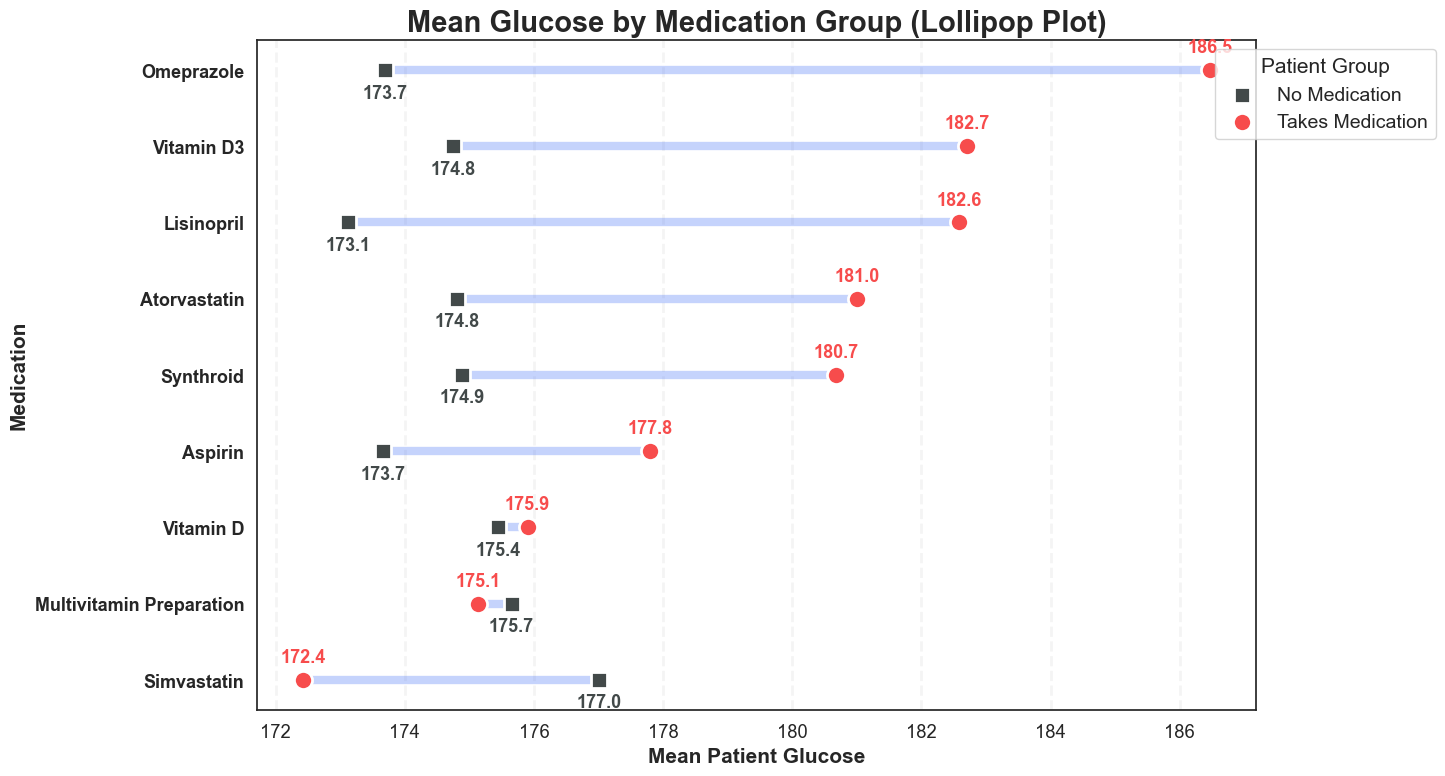

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Build med_means_df from df
# -------------------------------

# List of medication columns present in your dataset (from your column list)
med_cols_all = [
    'aspirin', 'simvastatin', 'lisinopril', 'vitamin_d', 'multivitamin_preparation',
    'omeprazole', 'atorvastatin', 'synthroid', 'vitamin_d3'
]

# Keep only meds that actually exist in df
med_cols = [c for c in med_cols_all if c in df.columns]
if len(med_cols) == 0:
    raise ValueError("No medication columns found in df. Please check column names.")

# Coerce medication columns to numeric 0/1 (handles True/False/Yes/No/strings)
df_med = df.copy()
for c in med_cols:
    df_med[c] = (
        df_med[c]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({'true': 1, 'false': 0, 'yes': 1, 'no': 0, 'y': 1, 'n': 0, 'nan': np.nan})
    )
    df_med[c] = pd.to_numeric(df_med[c], errors='coerce')  # -> NaN if not parseable

# Build patient-level table: mean glucose per patient + per-medication indicator
# For medication indicator at patient level, use max() to mark as 1 if med==1 at least once.
agg_dict = {'gl': 'mean'}
agg_dict.update({c: 'max' for c in med_cols})

patient_level = (
    df_med.groupby('id', as_index=False)
          .agg(agg_dict)
          .rename(columns={'gl': 'mean_glucose'})
)

# Ensure medication columns are 0/1 (NaN -> 0 meaning "no evidence of taking")
for c in med_cols:
    patient_level[c] = patient_level[c].fillna(0).clip(lower=0, upper=1).astype(int)

# Compute mean glucose for "takes med" vs "no med" at the PATIENT level
rows = []
min_group_size = 5  # avoid tiny groups misleading the averages; adjust if needed

for med in med_cols:
    takes_mask = patient_level[med] == 1
    no_mask    = patient_level[med] == 0

    n_takes = takes_mask.sum()
    n_no    = no_mask.sum()

    # Skip if either group is too small
    if n_takes < min_group_size or n_no < min_group_size:
        continue

    mean_with = patient_level.loc[takes_mask, 'mean_glucose'].mean()
    mean_without = patient_level.loc[no_mask, 'mean_glucose'].mean()

    rows.append({
        'Medication': med.replace('_', ' ').title(),
        'N (Takes Med)': int(n_takes),
        'N (No Med)': int(n_no),
        'Glucose (Takes Med)': float(mean_with),
        'Glucose (No Med)': float(mean_without),
        'Δ (With - Without)': float(mean_with - mean_without)
    })

if len(rows) == 0:
    raise ValueError("All medication groups are too small. Lower min_group_size or check your data.")

med_means_df = pd.DataFrame(rows).sort_values('Glucose (Takes Med)', ascending=True).reset_index(drop=True)
print(med_means_df)

# ---------------------------------------
# 2) Lollipop plot (your original design)
# ---------------------------------------
plt.figure(figsize=(15, 8))

y_labels = med_means_df['Medication']
y_pos    = np.arange(len(y_labels))
x_with   = med_means_df['Glucose (Takes Med)']
x_without= med_means_df['Glucose (No Med)']

# stems
plt.hlines(y_pos, x_without, x_with, color='#5A81F7', linewidth=6, zorder=1, alpha=0.35)

# endpoints
plt.scatter(x_without, y_pos, color='#424949', label='No Medication', zorder=3, s=130, marker='s',
            edgecolor='white', linewidth=2)
plt.scatter(x_with, y_pos, color='#F74C4C', label='Takes Medication', zorder=4, s=170, marker='o',
            edgecolor='white', linewidth=2)

# annotate numeric values
for xi, yi in zip(x_with, y_pos):
    plt.text(xi, yi + 0.18, f"{xi:.1f}", va='bottom', ha='center', fontsize=13,
             color='#F74C4C', fontweight='bold')
for xi, yi in zip(x_without, y_pos):
    plt.text(xi, yi - 0.18, f"{xi:.1f}", va='top', ha='center', fontsize=13,
             color='#424949', fontweight='bold')

plt.yticks(y_pos, y_labels, fontsize=13, fontweight='bold')
plt.xlabel("Mean Patient Glucose", fontsize=15, fontweight='bold')
plt.ylabel("Medication", fontsize=15, fontweight='bold')
plt.title("Mean Glucose by Medication Group (Lollipop Plot)", fontsize=21, fontweight='bold')

# legend
plt.legend(
    fontsize=14,
    title="Patient Group",
    title_fontsize=15,
    loc='upper right',
    bbox_to_anchor=(1.19, 1)
)
plt.grid(axis='x', linestyle='--', alpha=0.2, linewidth=2)
plt.tight_layout()
plt.show()


### **Violin Plot: Glucose Distribution for Each Disease Cohort**

**This plot displays the distribution of mean patient glucose for each disease cohort.  
Diseases are shown on the x-axis, and glucose values are on the y-axis.  
Bolded labels enhance clarity and professional appearance.**

---


/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/3003229436.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/wk/6g53_52x66xbm6gmgx0krkb40000gn/T/ipykernel_71860/3003229436.py:38: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.17`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


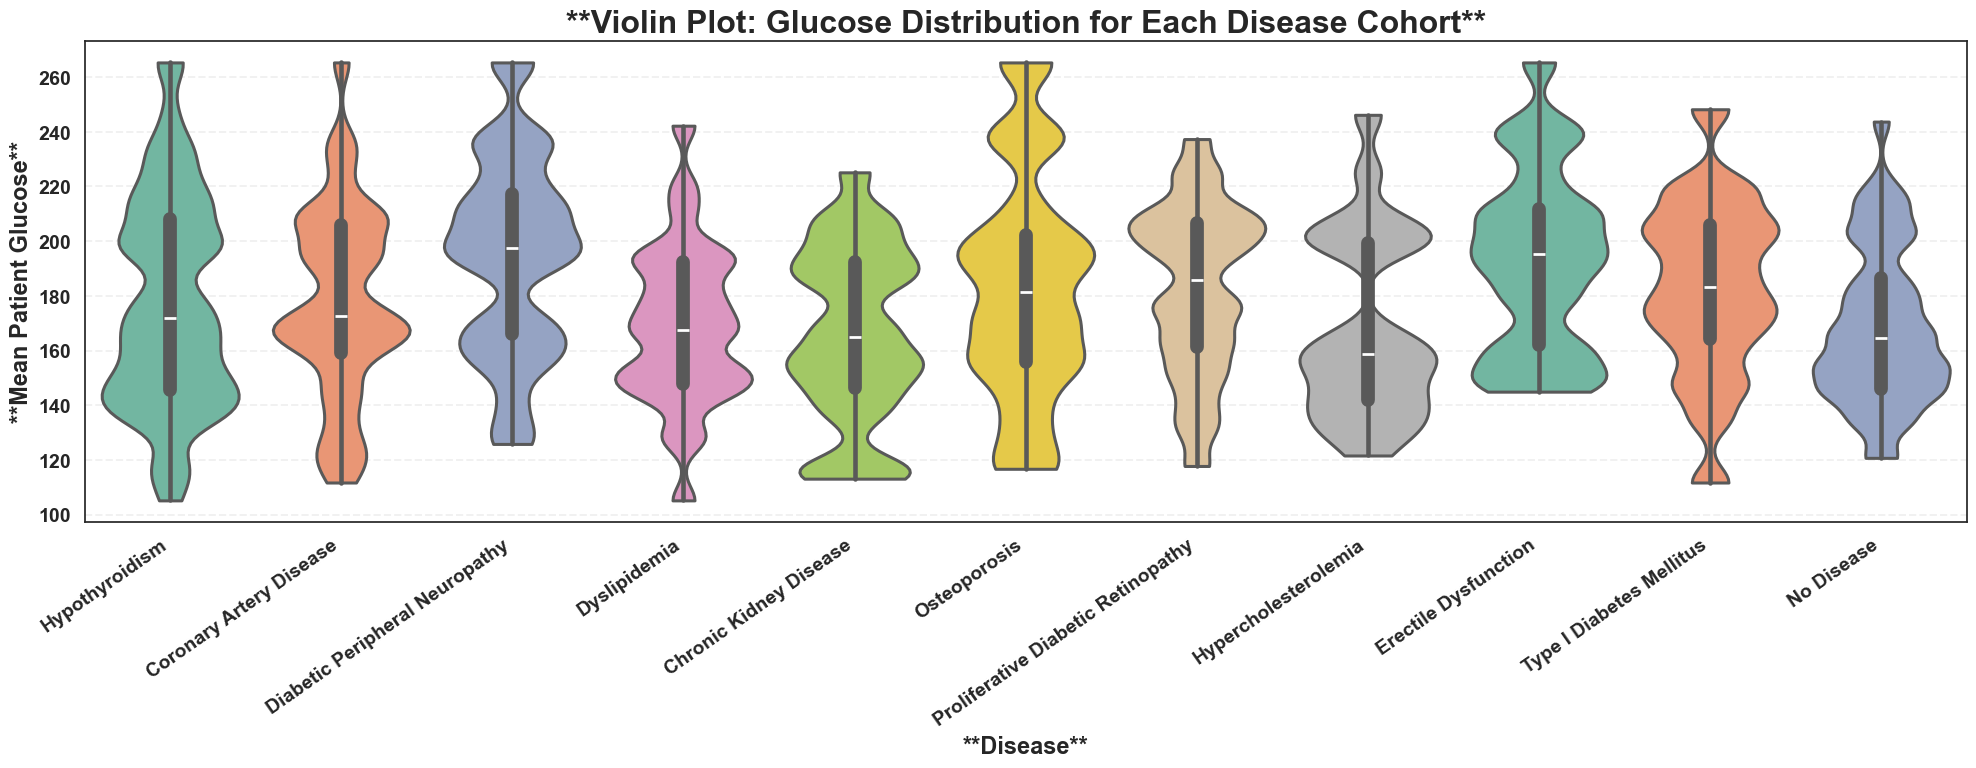

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

disease_cols = [
    'hypothyroidism',
    'coronary_artery_disease',
    'diabetic_peripheral_neuropathy',
    'dyslipidemia',
    'chronic_kidney_disease',
    'osteoporosis',
    'proliferative_diabetic_retinopathy',
    'hypercholesterolemia',
    'erectile_dysfunction',
    'type_i_diabetes_mellitus'
]
mean_gl = df.groupby('id')['gl'].mean()
patient_disease = df.groupby('id')[disease_cols].max().reset_index()
patient_disease['mean_glucose'] = patient_disease['id'].map(mean_gl)
patient_disease['No Disease'] = (patient_disease[disease_cols].sum(axis=1)==0).astype(int)

# Long-form for violin plot
violin_df = []
for disease in disease_cols:
    dname = disease.replace('_', ' ').title()
    vals = patient_disease[patient_disease[disease]==1]['mean_glucose']
    for v in vals:
        violin_df.append({'Disease': dname, 'Glucose': v})
# Add "No Disease"
vals = patient_disease[patient_disease['No Disease']==1]['mean_glucose']
for v in vals:
    violin_df.append({'Disease': 'No Disease', 'Glucose': v})

violin_df = pd.DataFrame(violin_df)
disease_order = [d.replace('_', ' ').title() for d in disease_cols] + ['No Disease']

plt.figure(figsize=(20, 9))
sns.violinplot(
    data=violin_df,
    x='Disease',
    y='Glucose',
    order=disease_order,
    palette='Set2',
    inner='box',
    linewidth=2.2,
    cut=0,
    bw=.17,
)
plt.title("**Violin Plot: Glucose Distribution for Each Disease Cohort**", fontsize=23, fontweight='bold')
plt.ylabel("**Mean Patient Glucose**", fontsize=17, fontweight='bold')
plt.xlabel("**Disease**", fontsize=17, fontweight='bold')
plt.xticks(
    rotation=35,               # Rotate for visibility
    ha='right',                # Anchor to the right
    fontsize=14, fontweight='bold'
)
plt.yticks(fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.28, linewidth=1.4)
plt.tight_layout(rect=[0, 0.12, 1, 1])   # Add space at the bottom for labels
plt.show()




### **Feature Engineering for Time Series Forecasting**

**Effective forecasting of glucose requires careful handling of temporal data.  
Raw datetime columns cannot be used directly in most models; instead, we extract informative time-based features from the timestamp for each measurement.  
Typical engineered features include hour of the day, day of the week, day of the month, and month, which may help capture diurnal or seasonal patterns in glucose variability.  
These engineered features, combined with patient attributes and prior glucose values, form the input for machine learning and deep learning models such as Random Forest, LSTM, and GRU.**


In [ ]:
import pandas as pd
import numpy as np

# Ensure 'time' is a datetime column
df['time'] = pd.to_datetime(df['time'])

# Sort by patient and time to maintain correct order for lags
df = df.sort_values(['id', 'time']).reset_index(drop=True)

# Extract time-based features
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month

# Convert all categorical/interval columns to codes
for col in df.select_dtypes(['category']).columns:
    df[f'{col}_code'] = df[col].cat.codes

# Optionally drop original interval/categorical columns after conversion
df = df.drop(columns=df.select_dtypes(['category']).columns)

# Create lagged glucose features for each patient
df['gl_lag1'] = df.groupby('id')['gl'].shift(1)
df['gl_lag2'] = df.groupby('id')['gl'].shift(2)

# Drop rows where lag features are NA (optional, for models that require full history)
df = df.dropna(subset=['gl_lag1', 'gl_lag2'])

# Build list of numeric, model-ready features (excluding ID, target, and time)
feature_cols = [
    col for col in df.columns
    if col not in ['id', 'gl', 'time'] and np.issubdtype(df[col], np.number)
]

# Preview engineered DataFrame
print(df[['id', 'time', 'gl', 'hour', 'dayofweek', 'day', 'month', 'gl_lag1', 'gl_lag2']].head())
print("\nModel-ready feature columns:", feature_cols)


   id                time     gl  hour  dayofweek  day  month  gl_lag1  \
2   1 1900-01-01 18:45:14  233.0    18          0    1      1    221.0   
3   1 1900-01-01 18:50:14  223.0    18          0    1      1    233.0   
4   1 1900-01-01 18:55:14  214.0    18          0    1      1    223.0   
5   1 1900-01-01 19:00:14  211.0    19          0    1      1    214.0   
6   1 1900-01-01 19:05:14  206.0    19          0    1      1    211.0   

   gl_lag2  
2    223.0  
3    221.0  
4    233.0  
5    223.0  
6    214.0  

Model-ready feature columns: ['edulevel', 'annualinc', 'dayswkex', 'dayswkdrinkalc', 'daysmonbingealc', 't1ddiagage', 'numhospdka', 'numshsincet1ddiag', 'unitsinstotal', 'nummetercheckday', 'height', 'weight', 'hypertension', 'hyperlipidemia', 'hypothyroidism', 'depression', 'coronary_artery_disease', 'diabetic_peripheral_neuropathy', 'dyslipidemia', 'chronic_kidney_disease', 'osteoporosis', 'proliferative_diabetic_retinopathy', 'hypercholesterolemia', 'erectile_dysfuncti

In [ ]:
# seq_len = 20  # Try longer window
# X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_len)
# X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_len)

# # LSTM with more units and Dropout
# from tensorflow.keras.layers import Dropout

# lstm = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
#     Dropout(0.3),
#     LSTM(32),
#     Dense(1)
# ])
# lstm.compile(optimizer='adam', loss='mse')
# lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, 
#          validation_split=0.2, callbacks=[EarlyStopping(patience=6, restore_best_weights=True)], verbose=1)
# lstm_pred = lstm.predict(X_test_seq).flatten()

# # GRU with more units and Dropout
# gru = Sequential([
#     GRU(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
#     Dropout(0.2),
#     GRU(32),
#     Dense(1)
# ])
# gru.compile(optimizer='adam', loss='mse')
# gru.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, 
#         validation_split=0.2, callbacks=[EarlyStopping(patience=6, restore_best_weights=True)], verbose=1)
# gru_pred = gru.predict(X_test_seq).flatten()

# # Metrics as before
# lstm_rmse, lstm_mae, lstm_r2, lstm_mape = regression_metrics(y_test_seq, lstm_pred)
# gru_rmse, gru_mae, gru_r2, gru_mape = regression_metrics(y_test_seq, gru_pred)

# print("\nAfter Tuning:")
# print("-" * 60)
# print("Model      |   RMSE   |   MAE   |   R²    |   MAPE")
# print("-" * 60)
# print(f"LSTM        | {lstm_rmse:.2f} | {lstm_mae:.2f} | {lstm_r2:.2f} | {lstm_mape:.1f}%")
# print(f"GRU         | {gru_rmse:.2f} | {gru_mae:.2f} | {gru_r2:.2f} | {gru_mape:.1f}%")
# print("-" * 60)


In [ ]:
df.columns.to_list()

['id',
 'gl',
 'time',
 'gender',
 'race',
 'edulevel',
 'annualinc',
 'maritalstatus',
 'dayswkex',
 'dayswkdrinkalc',
 'daysmonbingealc',
 't1ddiagage',
 'numhospdka',
 'numshsincet1ddiag',
 'insdeliverymethod',
 'unitsinstotal',
 'nummetercheckday',
 'height',
 'weight',
 'hypertension',
 'hyperlipidemia',
 'hypothyroidism',
 'depression',
 'coronary_artery_disease',
 'diabetic_peripheral_neuropathy',
 'dyslipidemia',
 'chronic_kidney_disease',
 'osteoporosis',
 'proliferative_diabetic_retinopathy',
 'hypercholesterolemia',
 'erectile_dysfunction',
 'type_i_diabetes_mellitus',
 'aspirin',
 'simvastatin',
 'lisinopril',
 'vitamin_d',
 'multivitamin_preparation',
 'omeprazole',
 'atorvastatin',
 'synthroid',
 'vitamin_d3',
 'bmi',
 'halfday',
 'hour',
 'dayofweek',
 'day',
 'month',
 'gl_lag1',
 'gl_lag2']

In [ ]:
# plt.figure(figsize=(15,4))
# for i, (name, preds) in enumerate(zip(["RF", "LSTM", "GRU"], [rf_pred, lstm_pred, gru_pred])):
#     plt.subplot(1, 3, i+1)
#     residuals = y_test - preds
#     plt.scatter(y_test, residuals, alpha=0.6)
#     plt.axhline(0, color='red', linestyle='--')
#     plt.xlabel("True Glucose")
#     plt.ylabel("Residuals (True - Predicted)")
#     plt.title(f"{name} Residuals")
# plt.suptitle("Residuals Plot")
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(15,4))
# for i, (name, preds) in enumerate(zip(["RF", "LSTM", "GRU"], [rf_pred, lstm_pred, gru_pred])):
#     plt.subplot(1, 3, i+1)
#     errors = y_test - preds
#     plt.hist(errors, bins=30, alpha=0.7)
#     plt.xlabel("Prediction Error")
#     plt.ylabel("Frequency")
#     plt.title(f"{name} Error Distribution")
# plt.suptitle("Prediction Error Distributions")
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(15,4))
# for i, (name, preds) in enumerate(zip(["RF", "LSTM", "GRU"], [rf_pred, lstm_pred, gru_pred])):
#     plt.subplot(1, 3, i+1)
#     abs_err = np.abs(y_test - preds)
#     sorted_err = np.sort(abs_err)
#     cdf = np.arange(len(sorted_err)) / float(len(sorted_err))
#     plt.plot(sorted_err, cdf)
#     plt.xlabel("Absolute Error")
#     plt.ylabel("Cumulative Probability")
#     plt.title(f"{name} Absolute Error CDF")
# plt.suptitle("Cumulative Distribution of Absolute Errors")
# plt.tight_layout()
# plt.show()


In [ ]:
# def recursive_multi_step_predict(model, X_init, steps, scaler_y, model_type='dl'):
#     preds = []
#     X_current = X_init.copy()
#     for _ in range(steps):
#         if model_type == 'rf':
#             # Random Forest expects 2D input
#             pred_scaled = model.predict(X_current.reshape(1, -1))[0]
            
#             preds.append(pred_scaled)

#             # Update X_current for RF: drop oldest glucose, append predicted glucose
#             # Assuming glucose is the first feature in flattened array
#             # So features per timestep * window_size = total features
#             n_features = len(feature_cols)
#             window_size = X_current.size // n_features
            
#             # Reshape flattened input into (window_size, n_features)
#             X_seq = X_current.reshape(window_size, n_features)
            
#             # Replace glucose value in last timestep with prediction
#             X_seq = np.roll(X_seq, -1, axis=0)  # shift sequence left by 1 timestep
#             X_seq[-1, 0] = pred_scaled  # update glucose in last timestep
            
#             # Flatten back to 1D vector
#             X_current = X_seq.flatten()

#         else:  # LSTM/GRU
#             pred_scaled = model.predict(X_current)[0, 0]
#             preds.append(pred_scaled)
            
#             # Update input sequence by dropping oldest step and appending new predicted glucose
#             # X_current shape: (1, window_size, n_features)
#             X_current = np.array(X_current)  # ensure numpy array
            
#             # Drop oldest timestep
#             X_current = X_current[:, 1:, :].copy()
            
#             # Prepare new step: copy last timestep features but replace glucose with prediction
#             new_step = X_current[:, -1:, :].copy()
#             new_step[0, 0, 0] = pred_scaled  # assuming 'gl' is first feature
            
#             # Append new step
#             X_current = np.concatenate([X_current, new_step], axis=1)
            
#     preds = np.array(preds).reshape(-1, 1)
#     return scaler_y.inverse_transform(preds).flatten()


In [ ]:
# steps = 12

# # For RF, initial input is 1D vector (flattened window)
# rf_input = X_input.reshape(-1)  # flatten from (1, window, features) to 1D

# rf_preds_multi = recursive_multi_step_predict(rf, rf_input, steps, scaler_y, model_type='rf')
# lstm_preds_multi = recursive_multi_step_predict(lstm, X_input, steps, scaler_y, model_type='dl')
# gru_preds_multi = recursive_multi_step_predict(gru, X_input, steps, scaler_y, model_type='dl')

# print(f"Next {steps} hours glucose predictions:")
# print("Random Forest:", rf_preds_multi)
# print("LSTM:", lstm_preds_multi)
# print("GRU:", gru_preds_multi)

hypertuneups 

precition

In [ ]:
# import matplotlib.pyplot as plt

# # Plot 12-hour predictions for each patient
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

# for idx, (pid, preds) in enumerate(forecast_results.items()):
#     hours = list(range(1, 13))
#     ax = axes[idx]
#     ax.plot(hours, preds['Random Forest'], label='Random Forest', marker='o')
#     ax.plot(hours, preds['LSTM'], label='LSTM', marker='s')
#     ax.plot(hours, preds['GRU'], label='GRU', marker='^')
#     ax.set_title(f"Patient {pid} - 12-Hour Glucose Forecast")
#     ax.set_ylabel("Predicted Glucose")
#     ax.grid(True)
#     ax.legend()

# axes[-1].set_xlabel("Hours Ahead")
# plt.tight_layout()
# plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Load and prepare
# df['time'] = pd.to_datetime(df['time'])
# df = df[['id', 'gl']].dropna()

# # Feature Engineering: aggregate per patient
# patient_features = df.groupby('id')['gl'].agg(['mean', 'std', 'min', 'max']).fillna(0)

# # Standardize
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(patient_features)

# # K-means Clustering (choose k=3 for now)
# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(X_scaled)
# patient_features['Cluster'] = clusters

# # Visualize
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=patient_features, x='mean', y='std', hue='Cluster', palette='Set2', s=100, edgecolor='black')
# plt.title("Patient Clusters by Glucose Behavior", fontsize=16, fontweight='bold')
# plt.xlabel("Mean Glucose", fontsize=12, fontweight='bold')
# plt.ylabel("Std Dev of Glucose", fontsize=12, fontweight='bold')
# plt.grid(True, linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()


In [ ]:
# # Only use one patient for everything
# pid = df_hr['id'].value_counts().index[0]
# df_one = df_hr[df_hr['id'] == pid].sort_values('hourly').copy()

NameError: name 'df_hr' is not defined

In [ ]:
# # Predict next 5 intervals (~2 hours) glucose for patient 1
# pid = 2
# patient_data = df[df['id'] == pid].copy()
# patient_data[feature_cols] = scaler_X.fit_transform(patient_data[feature_cols])
# patient_data['gl_scaled'] = scaler_y.fit_transform(patient_data[['gl']])

# X, y = create_sequences(patient_data[feature_cols].values, patient_data['gl_scaled'].values, window=6)
# X, y = X[:600], y[:600]
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# # Refit models on patient 1 data
# lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
# gru.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
# transformer.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# # Iterative prediction function for 5 intervals
# def iterative_predict(model, input_seq, steps=5):
#     preds = []
#     current_seq = input_seq.copy()
#     for _ in range(steps):
#         pred = model.predict(current_seq[np.newaxis, :, :])[0, 0]
#         preds.append(pred)

#         new_gl = pred
#         old_seq = current_seq.copy()

#         # Update lag feature (gl_lag1)
#         current_seq[1:, 1] = old_seq[:-1, 0]

#         # Update glucose (gl)
#         current_seq[:-1, 0] = old_seq[1:, 0]
#         current_seq[-1, 0] = new_gl

#         # Update minutes_since_start by adding approx 24 minutes per interval
#         current_seq[:-1, 2] = old_seq[1:, 2]
#         current_seq[-1, 2] = old_seq[-1, 2] + 24

#     return np.array(preds)

# input_seq = X_test[-1]

# lstm_pred_next5 = iterative_predict(lstm, input_seq, 5)
# gru_pred_next5 = iterative_predict(gru, input_seq, 5)
# transformer_pred_next5 = iterative_predict(transformer, input_seq, 5)

# # Inverse scale predictions and true glucose values
# true_glucose = scaler_y.inverse_transform(y_test[:5].reshape(-1, 1)).flatten()
# lstm_pred_glucose = scaler_y.inverse_transform(lstm_pred_next5.reshape(-1, 1)).flatten()
# gru_pred_glucose = scaler_y.inverse_transform(gru_pred_next5.reshape(-1, 1)).flatten()
# transformer_pred_glucose = scaler_y.inverse_transform(transformer_pred_next5.reshape(-1, 1)).flatten()

# # Plot predictions vs true for next 5 intervals (~2 hours)
# plt.figure(figsize=(10, 6))
# plt.plot(range(5), true_glucose, label='True Glucose')
# plt.plot(range(5), lstm_pred_glucose, label='LSTM Prediction')
# plt.plot(range(5), gru_pred_glucose, label='GRU Prediction')
# plt.plot(range(5), transformer_pred_glucose, label='Transformer Prediction')
# plt.title("Next 2 Hours (5 Intervals) Glucose Prediction for Patient 1")
# plt.xlabel("Intervals Ahead (~24 min each)")
# plt.ylabel("Glucose Level")
# plt.legend()
# plt.show()


In [ ]:
# Reload the newly uploaded file
file_path_new = '/Users/mine/office/finalyearproject/raw_data/split/weinstock-10-single.csv'
df_new = pd.read_csv(file_path_new)

# Show the columns and a sample to confirm structure
columns_new = df_new.columns.tolist()
df_new_sample = df_new.head(3)
columns_new, df_new_sample

# Parse timestamp and sort
df_new["time"] = pd.to_datetime(df_new["time"], errors='coerce')
df_new = df_new.sort_values("time").reset_index(drop=True)

# Create lag and rolling features for glucose
for lag in [1, 2, 3]:
    df_new[f"lag_{lag}"] = df_new["gl"].shift(lag)
for window in [3, 6, 12]:
    df_new[f"roll_mean_{window}"] = df_new["gl"].rolling(window=window).mean()

# Drop rows with NaNs created by lags/rolls
feature_cols = [f"lag_{lag}" for lag in [1, 2, 3]] + [f"roll_mean_{w}" for w in [3, 6, 12]]
df_feat = df_new.dropna(subset=feature_cols)

# Correlations
corrs = df_feat[["gl"] + feature_cols].corr()["gl"].sort_values(ascending=False)

# Show a sample and correlation for analysis selection
df_feat_sample = df_feat[["time", "gl"] + feature_cols].head(10)
corrs, df_feat_sample



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# CONFIG
PATIENT_ID_COL = 'id'
TEST_WINDOW = 60
SEQ_LEN = 12    # number of time steps for each input sequence

# 1. LOAD DATA
# df = pd.read_csv("/Users/mine/office/finalyearproject/raw_data/weinstock.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values([PATIENT_ID_COL, "time"]).reset_index(drop=True)

# 2. FEATURE ENGINEERING FOR ALL PATIENTS (just mean for 5min and lags)
dfs = []
for pid in df[PATIENT_ID_COL].unique():
    df_p = df[df[PATIENT_ID_COL]==pid].copy()
    df_p = df_p.set_index("time").resample("5min")['gl'].mean().reset_index()
    df_p[PATIENT_ID_COL] = pid
    for lag in range(1, SEQ_LEN+1):
        df_p[f"lag_{lag}"] = df_p["gl"].shift(lag)
    dfs.append(df_p)
df_feat = pd.concat(dfs, ignore_index=True)
feature_cols = [f"lag_{lag}" for lag in range(1, SEQ_LEN+1)]
all_cols = feature_cols + ["gl"]

df_clean = df_feat.dropna(subset=all_cols).copy().reset_index(drop=True)
patient_ids = df[PATIENT_ID_COL].unique()

# 3. BUILD WINDOWED DATA FOR ALL PATIENTS
X, y, ids = [], [], []
for pid in patient_ids:
    sub = df_clean[df_clean[PATIENT_ID_COL] == pid]
    for i in range(len(sub) - TEST_WINDOW):
        # skip if not enough future points for test window
        if i >= len(sub) - TEST_WINDOW:
            break
        X.append(sub.iloc[i][feature_cols].values.astype(float))
        y.append(sub.iloc[i]["gl"])
        ids.append(pid)
X = np.stack(X)
y = np.array(y)
ids = np.array(ids)

# Split into train/test indices by patient
test_mask = np.zeros_like(ids, dtype=bool)
for pid in patient_ids:
    pid_idx = np.where(ids == pid)[0]
    if len(pid_idx) < TEST_WINDOW + 1:
        continue
    test_mask[pid_idx[-TEST_WINDOW:]] = True
train_mask = ~test_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
ids_test = ids[test_mask]

# Scale
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
X_train_seq = X_train_scaled.reshape((-1, SEQ_LEN, 1))
X_test_seq = X_test_scaled.reshape((-1, SEQ_LEN, 1))

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

# -- TRAIN
print("\n--- Training LSTM on ALL patients ---\n")
lstm_model = build_lstm((SEQ_LEN, 1))
history_lstm = lstm_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])
print("\n--- Training GRU on ALL patients ---\n")
gru_model = build_gru((SEQ_LEN, 1))
history_gru = gru_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])
print("\n--- Training CNN on ALL patients ---\n")
cnn_model = build_cnn((SEQ_LEN, 1))
history_cnn = cnn_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])

# -- PREDICT for ALL patients' test set
lstm_pred = scaler_y.inverse_transform(lstm_model.predict(X_test_seq)).flatten()
gru_pred = scaler_y.inverse_transform(gru_model.predict(X_test_seq)).flatten()
cnn_pred = scaler_y.inverse_transform(cnn_model.predict(X_test_seq)).flatten()

lstm_r2 = r2_score(y_test, lstm_pred)
gru_r2 = r2_score(y_test, gru_pred)
cnn_r2 = r2_score(y_test, cnn_pred)

print(f"\nAGGREGATE R² SCORES (all test points, all patients):")
print(f"LSTM: {lstm_r2:.3f}")
print(f"GRU : {gru_r2:.3f}")
print(f"CNN : {cnn_r2:.3f}")

# --- AGGREGATE SCATTER PLOT (all patients) ---
plt.figure(figsize=(7,7))
plt.scatter(y_test, lstm_pred, alpha=0.5, label=f'LSTM (R²={lstm_r2:.2f})')
plt.scatter(y_test, gru_pred, alpha=0.5, label=f'GRU (R²={gru_r2:.2f})')
plt.scatter(y_test, cnn_pred, alpha=0.5, label=f'CNN (R²={cnn_r2:.2f})')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label="Identity")
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title("Aggregated All-Patient Scatter (Test Window, All Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PER-PATIENT: PREDICTION PLOTS ---
for pid in patient_ids:
    pidx = np.where(ids_test == pid)[0]
    if len(pidx) == 0:
        continue
    plt.figure(figsize=(12,5))
    plt.plot(range(1, len(pidx)+1), y_test[pidx], label="True Glucose", color="black", linewidth=2)
    plt.plot(range(1, len(pidx)+1), lstm_pred[pidx], label="LSTM", marker='o')
    plt.plot(range(1, len(pidx)+1), gru_pred[pidx], label="GRU", marker='o')
    plt.plot(range(1, len(pidx)+1), cnn_pred[pidx], label="CNN", marker='o')
    plt.xlabel('Minute')
    plt.ylabel('Glucose')
    plt.title(f'Patient {pid}: Last {TEST_WINDOW} min Glucose, All Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- EPOCH-WISE LOSS FOR ALL MODELS ---
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_gru.history['loss'], label='GRU Loss')
plt.plot(history_cnn.history['loss'], label='CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch-wise Training Loss (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# CONFIG
PATIENT_ID_COL = 'id'
TEST_WINDOW = 60
SEQ_LEN = 12

# 1. LOAD DATA
df = pd.read_csv("/Users/mine/office/finalyearproject/raw_data/weinstock.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values([PATIENT_ID_COL, "time"]).reset_index(drop=True)
patient_ids = df[PATIENT_ID_COL].unique()

# 2. Feature engineering (lags only)
dfs = []
for pid in patient_ids:
    df_p = df[df[PATIENT_ID_COL]==pid].copy()
    df_p = df_p.set_index("time").resample("5min")['gl'].mean().reset_index()
    df_p[PATIENT_ID_COL] = pid
    for lag in range(1, SEQ_LEN+1):
        df_p[f"lag_{lag}"] = df_p["gl"].shift(lag)
    dfs.append(df_p)
df_feat = pd.concat(dfs, ignore_index=True)
feature_cols = [f"lag_{lag}" for lag in range(1, SEQ_LEN+1)]
all_cols = feature_cols + ["gl"]
df_clean = df_feat.dropna(subset=all_cols).copy().reset_index(drop=True)

# 3. Build windowed data
X, y, ids = [], [], []
for pid in patient_ids:
    sub = df_clean[df_clean[PATIENT_ID_COL] == pid]
    for i in range(len(sub) - TEST_WINDOW):
        if i >= len(sub) - TEST_WINDOW:
            break
        X.append(sub.iloc[i][feature_cols].values.astype(float))
        y.append(sub.iloc[i]["gl"])
        ids.append(pid)
X = np.stack(X)
y = np.array(y)
ids = np.array(ids)

# 4. Split train/test indices by patient
test_mask = np.zeros_like(ids, dtype=bool)
for pid in patient_ids:
    pid_idx = np.where(ids == pid)[0]
    if len(pid_idx) < TEST_WINDOW + 1:
        continue
    test_mask[pid_idx[-TEST_WINDOW:]] = True
train_mask = ~test_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
ids_test = ids[test_mask]

# 5. Scaling & sequencing
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
X_train_seq = X_train_scaled.reshape((-1, SEQ_LEN, 1))
X_test_seq = X_test_scaled.reshape((-1, SEQ_LEN, 1))

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse')
    return model

# Train models on all patients' train split
lstm_model = build_lstm((SEQ_LEN, 1))
history_lstm = lstm_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])
gru_model = build_gru((SEQ_LEN, 1))
history_gru = gru_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])
cnn_model = build_cnn((SEQ_LEN, 1))
history_cnn = cnn_model.fit(X_train_seq, y_train_scaled, epochs=20, batch_size=64, verbose=2, callbacks=[early_stop])

# Predictions
lstm_pred = scaler_y.inverse_transform(lstm_model.predict(X_test_seq)).flatten()
gru_pred = scaler_y.inverse_transform(gru_model.predict(X_test_seq)).flatten()
cnn_pred = scaler_y.inverse_transform(cnn_model.predict(X_test_seq)).flatten()

lstm_r2 = r2_score(y_test, lstm_pred)
gru_r2 = r2_score(y_test, gru_pred)
cnn_r2 = r2_score(y_test, cnn_pred)

# --- Separate scatter plot for each model (all patients, aggregated) ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, lstm_pred, alpha=0.6, label=f"LSTM (R²={lstm_r2:.3f})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title("LSTM: All Patients (Aggregated Test)")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, gru_pred, alpha=0.6, label=f"GRU (R²={gru_r2:.3f})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title("GRU: All Patients (Aggregated Test)")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, cnn_pred, alpha=0.6, label=f"CNN (R²={cnn_r2:.3f})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title("CNN: All Patients (Aggregated Test)")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# --- Aggregated ROC/Identity plot (all models) ---
plt.figure(figsize=(7,7))
plt.scatter(y_test, lstm_pred, alpha=0.3, label=f'LSTM (R²={lstm_r2:.2f})')
plt.scatter(y_test, gru_pred, alpha=0.3, label=f'GRU (R²={gru_r2:.2f})')
plt.scatter(y_test, cnn_pred, alpha=0.3, label=f'CNN (R²={cnn_r2:.2f})')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label="Identity")
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title("Aggregated All-Patient ROC-like Scatter (Test Window, All Models)")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# --- Epoch-wise Loss (all models) ---
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_gru.history['loss'], label='GRU Loss')
plt.plot(history_cnn.history['loss'], label='CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch-wise Training Loss (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- PREDICTION AND PLOTS FOR A SINGLE PATIENT (example: patient_id = 2) ---
single_patient_id = 14
pidx = np.where(ids_test == single_patient_id)[0]
if len(pidx) > 0:
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(pidx)+1), y_test[pidx], label="True Glucose", color="black", linewidth=2)
    plt.plot(range(1, len(pidx)+1), lstm_pred[pidx], label="LSTM", marker='o')
    plt.plot(range(1, len(pidx)+1), gru_pred[pidx], label="GRU", marker='o')
    plt.plot(range(1, len(pidx)+1), cnn_pred[pidx], label="CNN", marker='o')
    plt.xlabel('Minute')
    plt.ylabel('Glucose')
    plt.title(f'Patient {single_patient_id}: Last {TEST_WINDOW} min Glucose, All Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No test data for patient {single_patient_id}")


In [ ]:
# --- PREDICTION AND PLOTS FOR A SINGLE PATIENT (example: patient_id = 2) ---
single_patient_id = 15
pidx = np.where(ids_test == single_patient_id)[0]
if len(pidx) > 0:
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(pidx)+1), y_test[pidx], label="True Glucose", color="black", linewidth=2)
    plt.plot(range(1, len(pidx)+1), lstm_pred[pidx], label="LSTM", marker='o')
    plt.plot(range(1, len(pidx)+1), gru_pred[pidx], label="GRU", marker='o')
    plt.plot(range(1, len(pidx)+1), cnn_pred[pidx], label="CNN", marker='o')
    plt.xlabel('Minute')
    plt.ylabel('Glucose')
    plt.title(f'Patient {single_patient_id}: Last {TEST_WINDOW} min Glucose, All Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"No test data for patient {single_patient_id}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# CONFIG
PATIENT_ID_COL = 'id'
TEST_WINDOW = 60
SEQ_LEN = 12
N_PATIENTS = 10   # Only show predictions/plots for first 10

# 1. LOAD DATA
df = pd.read_csv("/Users/mine/office/finalyearproject/raw_data/weinstock.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values([PATIENT_ID_COL, "time"]).reset_index(drop=True)
all_patient_ids = df[PATIENT_ID_COL].unique()
patient_ids_to_plot = all_patient_ids[:N_PATIENTS]

# 2. FEATURE ENGINEERING FOR ALL PATIENTS (just mean for 5min and lags)
dfs = []
for pid in all_patient_ids:   # <--- process ALL patients here!
    df_p = df[df[PATIENT_ID_COL]==pid].copy()
    df_p = df_p.set_index("time").resample("5min")['gl'].mean().reset_index()
    df_p[PATIENT_ID_COL] = pid
    for lag in range(1, SEQ_LEN+1):
        df_p[f"lag_{lag}"] = df_p["gl"].shift(lag)
    dfs.append(df_p)
df_feat = pd.concat(dfs, ignore_index=True)
feature_cols = [f"lag_{lag}" for lag in range(1, SEQ_LEN+1)]
all_cols = feature_cols + ["gl"]

df_clean = df_feat.dropna(subset=all_cols).copy().reset_index(drop=True)

# 3. BUILD WINDOWED DATA FOR ALL PATIENTS
X, y, ids = [], [], []
for pid in all_patient_ids:
    sub = df_clean[df_clean[PATIENT_ID_COL] == pid]
    for i in range(len(sub) - TEST_WINDOW):
        if i >= len(sub) - TEST_WINDOW:
            break
        X.append(sub.iloc[i][feature_cols].values.astype(float))
        y.append(sub.iloc[i]["gl"])
        ids.append(pid)
X = np.stack(X)
y = np.array(y)
ids = np.array(ids)

# 4. TRAIN/TEST SPLIT BY PATIENT
test_mask = np.zeros_like(ids, dtype=bool)
for pid in all_patient_ids:
    pid_idx = np.where(ids == pid)[0]
    if len(pid_idx) < TEST_WINDOW + 1:
        continue
    test_mask[pid_idx[-TEST_WINDOW:]] = True
train_mask = ~test_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
ids_test = ids[test_mask]

# 5. SCALING & SEQUENCING
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
X_train_seq = X_train_scaled.reshape((-1, SEQ_LEN, 1))
X_test_seq = X_test_scaled.reshape((-1, SEQ_LEN, 1))

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# === MODELS (tuned for better CNN performance) ===
def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=4, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# TRAIN ALL MODELS ON ALL-PATIENTS TRAIN SPLIT
print("\n--- Training LSTM on ALL patients ---\n")
lstm_model = build_lstm((SEQ_LEN, 1))
history_lstm = lstm_model.fit(X_train_seq, y_train_scaled, epochs=40, batch_size=32, verbose=2, callbacks=[early_stop])

print("\n--- Training GRU on ALL patients ---\n")
gru_model = build_gru((SEQ_LEN, 1))
history_gru = gru_model.fit(X_train_seq, y_train_scaled, epochs=40, batch_size=32, verbose=2, callbacks=[early_stop])

print("\n--- Training CNN on ALL patients ---\n")
cnn_model = build_cnn((SEQ_LEN, 1))
history_cnn = cnn_model.fit(X_train_seq, y_train_scaled, epochs=40, batch_size=32, verbose=2, callbacks=[early_stop])

# -- PREDICT for ALL patients' test set
lstm_pred = scaler_y.inverse_transform(lstm_model.predict(X_test_seq)).flatten()
gru_pred = scaler_y.inverse_transform(gru_model.predict(X_test_seq)).flatten()
cnn_pred = scaler_y.inverse_transform(cnn_model.predict(X_test_seq)).flatten()

lstm_r2 = r2_score(y_test, lstm_pred)
gru_r2 = r2_score(y_test, gru_pred)
cnn_r2 = r2_score(y_test, cnn_pred)

print(f"\nAGGREGATE R² SCORES (all test points, all patients):")
print(f"LSTM: {lstm_r2:.3f}")
print(f"GRU : {gru_r2:.3f}")
print(f"CNN : {cnn_r2:.3f}")



# --- EPOCH-WISE LOSS FOR ALL MODELS ---
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_gru.history['loss'], label='GRU Loss')
plt.plot(history_cnn.history['loss'], label='CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch-wise Training Loss (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- LSTM: True vs. Prediction Scatter ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, lstm_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title(f"LSTM: True vs. Predicted (R²={r2_score(y_test, lstm_pred):.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- GRU: True vs. Prediction Scatter ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, gru_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title(f"GRU: True vs. Predicted (R²={r2_score(y_test, gru_pred):.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- CNN: True vs. Prediction Scatter ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, cnn_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Glucose")
plt.ylabel("Predicted Glucose")
plt.title(f"CNN: True vs. Predicted (R²={r2_score(y_test, cnn_pred):.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate metrics
metrics = ['R²', 'RMSE', 'MAE']
model_names = ['LSTM', 'GRU', 'CNN']

r2_vals = [
    r2_score(y_test, lstm_pred),
    r2_score(y_test, gru_pred),
    r2_score(y_test, cnn_pred)
]
rmse_vals = [
    np.sqrt(mean_squared_error(y_test, lstm_pred)),
    np.sqrt(mean_squared_error(y_test, gru_pred)),
    np.sqrt(mean_squared_error(y_test, cnn_pred))
]
mae_vals = [
    mean_absolute_error(y_test, lstm_pred),
    mean_absolute_error(y_test, gru_pred),
    mean_absolute_error(y_test, cnn_pred)
]

# Organize values for grouped bar plot
bar_width = 0.25
x = np.arange(len(model_names))
plt.figure(figsize=(12,6))

# Plot grouped bars
plt.bar(x - bar_width, r2_vals, width=bar_width, label='R²', color='#1f77b4')
plt.bar(x, rmse_vals, width=bar_width, label='RMSE', color='#ff7f0e')
plt.bar(x + bar_width, mae_vals, width=bar_width, label='MAE', color='#2ca02c')

# Annotate bars with values
for i, vals in enumerate([r2_vals, rmse_vals, mae_vals]):
    for j, v in enumerate(vals):
        plt.text(j + (i-1)*bar_width, v + 0.01*(max(vals)), f"{v:.3f}", 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, model_names, fontsize=13)
plt.ylabel('Metric Value', fontsize=13)
plt.title('Model Performance Comparison (Test Set)', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, frameon=True)
plt.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# Make predictions on the training set (already scaled and reshaped)
lstm_pred_train = scaler_y.inverse_transform(lstm_model.predict(X_train_seq)).flatten()
gru_pred_train = scaler_y.inverse_transform(gru_model.predict(X_train_seq)).flatten()
cnn_pred_train = scaler_y.inverse_transform(cnn_model.predict(X_train_seq)).flatten()


In [ ]:
plt.figure(figsize=(16,6))
plt.plot(y_train, label='True Glucose (Train)', color='black', linewidth=2)
plt.plot(lstm_pred_train, label='LSTM', alpha=0.7)
plt.plot(gru_pred_train, label='GRU', alpha=0.7)
plt.plot(cnn_pred_train, label='CNN', alpha=0.7)
plt.xlabel("Training Sample Index")
plt.ylabel("Glucose Value")
plt.title("Model Predictions vs. True Glucose (Training Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(y_test, label='True Glucose', color='black', linewidth=2)
plt.plot(lstm_pred, label='LSTM', alpha=0.8)
plt.plot(gru_pred, label='GRU', alpha=0.8)
plt.plot(cnn_pred, label='CNN', alpha=0.8)
plt.xlabel("Sample Index (Test Set Order)")
plt.ylabel("Glucose")
plt.title("Model Predictions vs. True Glucose (All Test Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Threshold for high glucose ---
threshold = 140

# Binarize y_test
y_test_bin = (y_test > threshold).astype(int)

# ROC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_bin, lstm_pred)
auc_lstm = auc(fpr_lstm, tpr_lstm)

# ROC for GRU
fpr_gru, tpr_gru, _ = roc_curve(y_test_bin, gru_pred)
auc_gru = auc(fpr_gru, tpr_gru)

# ROC for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_bin, cnn_pred)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC={auc_lstm:.3f})")
plt.plot(fpr_gru, tpr_gru, label=f"GRU (AUC={auc_gru:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN (AUC={auc_cnn:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models (Threshold = 140 mg/dL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_gru.history['loss'], label='GRU Loss')
plt.plot(history_cnn.history['loss'], label='CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Epoch-wise Training Loss (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Binarize (High: > 140, Normal: <= 140)
threshold = 140
y_test_bin = (y_test > threshold).astype(int)
lstm_bin = (lstm_pred > threshold).astype(int)
gru_bin  = (gru_pred  > threshold).astype(int)
cnn_bin  = (cnn_pred  > threshold).astype(int)

# LSTM
cm_lstm = confusion_matrix(y_test_bin, lstm_bin)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Normal (<=140)', 'High (>140)'])
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: LSTM")
plt.show()

# GRU
cm_gru = confusion_matrix(y_test_bin, gru_bin)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=['Normal (<=140)', 'High (>140)'])
disp_gru.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix: GRU")
plt.show()

# CNN
cm_cnn = confusion_matrix(y_test_bin, cnn_bin)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=['Normal (<=140)', 'High (>140)'])
disp_cnn.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix: CNN")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(y_test, label='True Glucose', color='black', linewidth=2)
plt.plot(lstm_pred, label='LSTM Prediction', linestyle='-')
plt.plot(gru_pred, label='GRU Prediction', linestyle='--')
plt.plot(cnn_pred, label='CNN Prediction', linestyle=':')
plt.xlabel("Test Sample Index")
plt.ylabel("Glucose Value")
plt.title("Comparison of Model Predictions vs. True Glucose (All Test Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# --- SET PATIENT ID ---
single_pid = 14  # <--- change this to your patient id

# --- SELECT INDICES FOR THE PATIENT ---
pidx = np.where(ids_test == single_pid)[0]
if len(pidx) < 60:
    print(f"Not enough test data for patient {single_pid}.")
else:
    # Select the last 60 values
    idx_last_60 = pidx[-60:]
    minutes = np.arange(60)

    plt.figure(figsize=(14,5))
    plt.plot(minutes, y_test[idx_last_60], label='True Glucose', color='black')
    plt.plot(minutes, lstm_pred[idx_last_60], label='LSTM', marker='o')
    plt.plot(minutes, gru_pred[idx_last_60], label='GRU', marker='o')
    plt.plot(minutes, cnn_pred[idx_last_60], label='CNN', marker='o')
    plt.xlabel("Minute")
    plt.ylabel("Glucose")
    plt.title(f"Patient {single_pid}: Last 60 min Glucose, All Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Calculate and display R² scores for this patient ---
    r2_lstm = r2_score(y_test[pidx], lstm_pred[pidx])
    r2_gru  = r2_score(y_test[pidx], gru_pred[pidx])
    r2_cnn  = r2_score(y_test[pidx], cnn_pred[pidx])

    print(f"Patient {single_pid} R² Scores:")
    print(f"  LSTM: {r2_lstm:.3f}")
    print(f"  GRU : {r2_gru:.3f}")
    print(f"  CNN : {r2_cnn:.3f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# --- SET PATIENT ID ---
single_pid = 200  # <--- change this to your patient id

# --- SELECT INDICES FOR THE PATIENT ---
pidx = np.where(ids_test == single_pid)[0]
if len(pidx) < 60:
    print(f"Not enough test data for patient {single_pid}.")
else:
    # Select the last 60 values
    idx_last_60 = pidx[-60:]
    minutes = np.arange(60)

    plt.figure(figsize=(14,5))
    plt.plot(minutes, y_test[idx_last_60], label='True Glucose', color='black')
    plt.plot(minutes, lstm_pred[idx_last_60], label='LSTM', marker='o')
    plt.plot(minutes, gru_pred[idx_last_60], label='GRU', marker='o')
    plt.plot(minutes, cnn_pred[idx_last_60], label='CNN', marker='o')
    plt.xlabel("Minute")
    plt.ylabel("Glucose")
    plt.title(f"Patient {single_pid}: Last 60 min Glucose, All Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Calculate and display R² scores for this patient ---
    r2_lstm = r2_score(y_test[pidx], lstm_pred[pidx])
    r2_gru  = r2_score(y_test[pidx], gru_pred[pidx])
    r2_cnn  = r2_score(y_test[pidx], cnn_pred[pidx])

    print(f"Patient {single_pid} R² Scores:")
    print(f"  LSTM: {r2_lstm:.3f}")
    print(f"  GRU : {r2_gru:.3f}")
    print(f"  CNN : {r2_cnn:.3f}")
